# Detección de anomalías en un marco de auditoría continua

## 10. Datos balanceados - Modelos supervisados

### 10.1. Split del dataset

Split del dataset para reservar un conjunto de datos para validación posterior al entrenamiento y desarrollo de los modelos.

In [1]:
# Importación de librerías
import pandas as pd
import numpy as np
import os
import time
import joblib

In [2]:
# Filtro de warnings.
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Carga del dataset.
os.chdir('..')
df = pd.read_csv('df_preprocessed.csv')
df.head()

,day,hour,amount,idOrig,oldbalanceOrig,newbalanceOrig,idDest,oldbalanceDest,newbalanceDest,Cash_in,Cash_out,Debit,Payment,Transfer,isFraud,isFlaggedFraud
0,1,1,9839.64,0,170136.0,160296.36,6353307,0.0,0.0,0,0,0,1,0,0,0
1,1,1,1864.28,1,21249.0,19384.72,6353308,0.0,0.0,0,0,0,1,0,0,0
2,1,1,181.00,2,181.0,0.00,6353309,0.0,0.0,0,0,0,0,1,1,0
3,1,1,181.00,3,181.0,0.00,6353310,21182.0,0.0,0,1,0,0,0,1,0
4,1,1,11668.14,4,41554.0,29885.86,6353311,0.0,0.0,0,0,0,1,0,0,0


In [4]:
# Split del dataset para reservar un conjunto de validación.
from sklearn.model_selection import train_test_split
df_training, df_validation = train_test_split(df, test_size = 0.2, random_state = 42, shuffle = True, stratify = np.array(df['isFraud']))

In [5]:
# Control de frecuencias de clases.
print('Proporcion de clases para dataset de training: %.4f' % (df_training['isFraud'].value_counts()[1] / df_training['isFraud'].value_counts()[0]))
print('Proporcion de clases para dataset de validación: %.4f' % (df_validation['isFraud'].value_counts()[1] / df_validation['isFraud'].value_counts()[0]))

Proporcion de clases para dataset de training: 0.0013
Proporcion de clases para dataset de validación: 0.0013


### 10.2. Balanceo de datos

Para el balanceo de datos, se recurre a una técnica híbrida:
- Por un lado, se submuestrean los registros de la clase mayoritaria, utilizando muestreo sin reposición.
- Por otro lado, se sobremuestrean los registros de la clase minoritaria, utilizando muestreo con reposición.
- Se recurre a un valor de k, que representa el factor de muestreo. A mayor k, mayor es la participación de casos de fraude dentro del nuevo dataset.

In [6]:
# Función para el balanceo de datos.
from sklearn.utils import resample

def balancing(X, y, k):
    # X = dataframe; y = series; k = float
    
    # Submuestreo de la clase mayoritaria.
    index_majority_downsampled = resample(X[y == 0], 
                                       replace = False,
                                       n_samples = int(len(X[y == 0]) * (1 - k)),
                                       random_state = 42).index
    
    # Sobremuestreo de la clase minoritaria.
    index_minority_oversampled = resample(X[y == 1], 
                                       replace = True,
                                       n_samples = int(len(X[y == 1]) * (1 + k)),
                                       random_state = 42).index
    
    indexes = list(index_majority_downsampled) + list(index_minority_oversampled)
    
    return indexes

### 10.3. Entrenamiento de modelos

#### 10.3.1. Preparación del dataset y funciones

In [7]:
# F1 score, also known as balanced F-score or F-measure.
# The F1 score can be interpreted as a harmonic mean of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:
# F1 = 2 * (precision * recall) / (precision + recall)
# In the multi-class and multi-label case, this is the average of the F1 score of each class with weighting depending on the average parameter.

# Funciones para optimización y reporting.
import json
from datetime import datetime
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from hyperopt import fmin, hp, tpe, space_eval, Trials
from hyperopt.early_stop import no_progress_loss

# Función objetivo.
def objective_func(search_space):
    
    global counter, scorings, estimator
    start_time = time.time()
    counter += 1
    
    estimator.set_params(**search_space['params'])
    
    skf = StratifiedKFold(random_state = 42, n_splits = 4, shuffle = True)    
    
    scores = {'Recall': [],
              'Precision': [],
              'AUC': [],
              'Accuracy': [],
              'F1-Score': []
             }
    
    for train, test in skf.split(X = X, y = y):
        
        X_train = X.iloc[train, :]
        X_test = X.iloc[test, :]
        y_train = y.iloc[train]
        y_test = y.iloc[test]

        indexes_train = balancing(X_train, y_train, 0.8)
        indexes_test = balancing(X_test, y_test, 0.8)

        X_train = X_train.loc[indexes_train, :]
        X_test = X_test.loc[indexes_test, :]
        y_train = y_train.loc[indexes_train]
        y_test = y_test.loc[indexes_test]
        
        estimator.fit(X_train, y_train)
        y_pred = estimator.predict(X_test)
        
        scores['Recall'].append(recall_score(y_test, y_pred))
        scores['Precision'].append(precision_score(y_test, y_pred))
        scores['AUC'].append(roc_auc_score(y_test, y_pred))
        scores['Accuracy'].append(accuracy_score(y_test, y_pred))
        scores['F1-Score'].append(f1_score(y_test, y_pred))
    
    loss = 1 - np.mean(scores['F1-Score']) + np.std(scores['F1-Score'])

    scorings.append({'trial': counter,
                     'search_space' : str(search_space),
                     'scorings' : {'Recall': np.mean(scores['Recall']),
                                   'Precision': np.mean(scores['Precision']),
                                   'AUC': np.mean(scores['AUC']),
                                   'Accuracy': np.mean(scores['Accuracy']),
                                   'Recall_Std': np.std(scores['Recall']),
                                   'Precision_Std': np.std(scores['Precision']),
                                   'AUC_Std': np.std(scores['AUC']),
                                   'Accuracy_Std': np.std(scores['Accuracy']),
                                   'F1-Score': np.mean(scores['F1-Score'])}
                    }
                   )
    
    elapsed_time = time.time() - start_time
    
    print('Trial: %i | Loss: %.4f | Elapsed_time: %.4f seconds' % (counter, loss, elapsed_time))
    
    return loss

# Función para la impresión de resultados.
def hyperopt_printer(trials):
    print('\nBest Trial:')
    print('Trial ID :', trials.best_trial['tid'])
    print('Loss :', trials.best_trial['result']['loss'])
    print('Params :', space_eval(search_space, best_params), end = '\n\n')

# Función para exportación de resultados a formato JSON.
def json_export(scorings):
    try:
        os.mkdir('hyperopt_optimizations')
    except:
        None

    now = datetime.now()
    dt_string = now.strftime("%Y%m%d_%H%M%S")
    path = os.getcwd() + '\hyperopt_optimizations\\'
    filename = 'Opt_' + dt_string + '.json'

    f = open(path + filename, 'w')
    json.dump(scorings, f)
    f.close()
    print('Json file: ' + dt_string + '.json', end = '\n\n')

# Función para la obtención de resultados en formato tabla para visualizar scorings y desvios estándar.
def scorings_to_df(scorings):
    scorings_df = pd.DataFrame(columns = list(scorings[0]['scorings'].keys()))
    for scoring in scorings:
        scorings_df = scorings_df.append(scoring['scorings'], ignore_index = True)

    print('Scoring details:', end = '\n\n')
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000):  # more options can be specified also
        print(scorings_df)

    return scorings_df

#### 10.3.2. Árboles de Decisión (Decision trees)

##### 10.3.2.1. Primera optimización de parámetros

Para la optimización de hiperparámetros, se utiliza una alternativa de búsqueda guidada, mediante la implementación de la librería HyperOpt y el algoritmo Tree Parzen Estimator, basado en la Optimización Bayesiana.

In [11]:
# Importación de librerías
from sklearn.tree import DecisionTreeClassifier

# Definición del espacio / dominio de parámetros.
search_space = {'estimator' : DecisionTreeClassifier(),
                'params' : {'criterion' : hp.choice('criterion', ['entropy', 'gini']),
                            'splitter' : hp.choice('splitter', ['best', 'random']),
                            'max_depth' : hp.qnormal('max_depth', 12, 5, 1),
                            'min_samples_split' : hp.choice('min_samples_split', [2, 3]),
                            'min_samples_leaf' : hp.choice('min_samples_leaf', [1, 2, 3]),
                            'class_weight' : hp.choice('class_weight', [None, 'balanced']),
                            'random_state' : 42}}
selected_columns = ['isFraud', 'isFlaggedFraud']
X = df_training.drop(labels = selected_columns, axis = 1)
y = df_training['isFraud']
estimator = DecisionTreeClassifier()

# Implementación de Hyperopt
counter = -1
scorings = list()
rstate = np.random.default_rng(42)
trials = Trials() # Para el logging de resultados.
best_params = fmin(fn = objective_func, 
                   space = search_space, 
                   algo = tpe.suggest, 
                   max_evals = 100, 
                   trials = trials, 
                   early_stop_fn = no_progress_loss(50), 
                   rstate = rstate)

# Impresión de resultados.
hyperopt_printer(trials)
json_export(scorings)
scorings_to_df(scorings)

Trial: 0 | Loss: 0.1347 | Elapsed_time: 35.9936 seconds
Trial: 1 | Loss: 0.4829 | Elapsed_time: 15.7799 seconds                           
Trial: 2 | Loss: 0.0806 | Elapsed_time: 33.6595 seconds                           
Trial: 3 | Loss: 0.1884 | Elapsed_time: 14.4374 seconds                           
Trial: 4 | Loss: 0.0907 | Elapsed_time: 29.9715 seconds                           
Trial: 5 | Loss: 0.8591 | Elapsed_time: 13.6655 seconds                           
Trial: 6 | Loss: 0.2147 | Elapsed_time: 14.6445 seconds                           
Trial: 7 | Loss: 1.0000 | Elapsed_time: 14.5330 seconds                           
Trial: 8 | Loss: 0.1347 | Elapsed_time: 35.6423 seconds                           
Trial: 9 | Loss: 0.4566 | Elapsed_time: 13.3248 seconds                           
Trial: 10 | Loss: 0.1135 | Elapsed_time: 30.0082 seconds                           
Trial: 11 | Loss: 0.8584 | Elapsed_time: 13.3896 seconds                           
Trial: 12 | Loss: 0.0901 | El

,Recall,Precision,AUC,Accuracy,Recall_Std,Precision_Std,AUC_Std,Accuracy_Std,F1-Score
0,0.812248,0.943448,0.905840,0.997280,0.017477,0.008076,0.008697,0.000125,0.872760
1,0.900375,0.411017,0.942517,0.983690,0.015966,0.047350,0.008297,0.002977,0.562857
2,0.907391,0.937389,0.953343,0.998238,0.003205,0.005118,0.001596,0.000064,0.922135
3,0.742050,0.933369,0.870717,0.996426,0.017013,0.013980,0.008552,0.000299,0.826739
4,0.881598,0.945843,0.940505,0.998057,0.005605,0.008069,0.002775,0.000077,0.912551
...,...,...,...,...,...,...,...,...,...
73,0.917964,0.946486,0.958680,0.998460,0.001378,0.004862,0.000680,0.000054,0.931999
74,0.917964,0.946486,0.958680,0.998460,0.001378,0.004862,0.000680,0.000054,0.931999
75,0.917964,0.946486,0.958680,0.998460,0.001378,0.004862,0.000680,0.000054,0.931999
76,0.917964,0.946486,0.958680,0.998460,0.001378,0.004862,0.000680,0.000054,0.931999


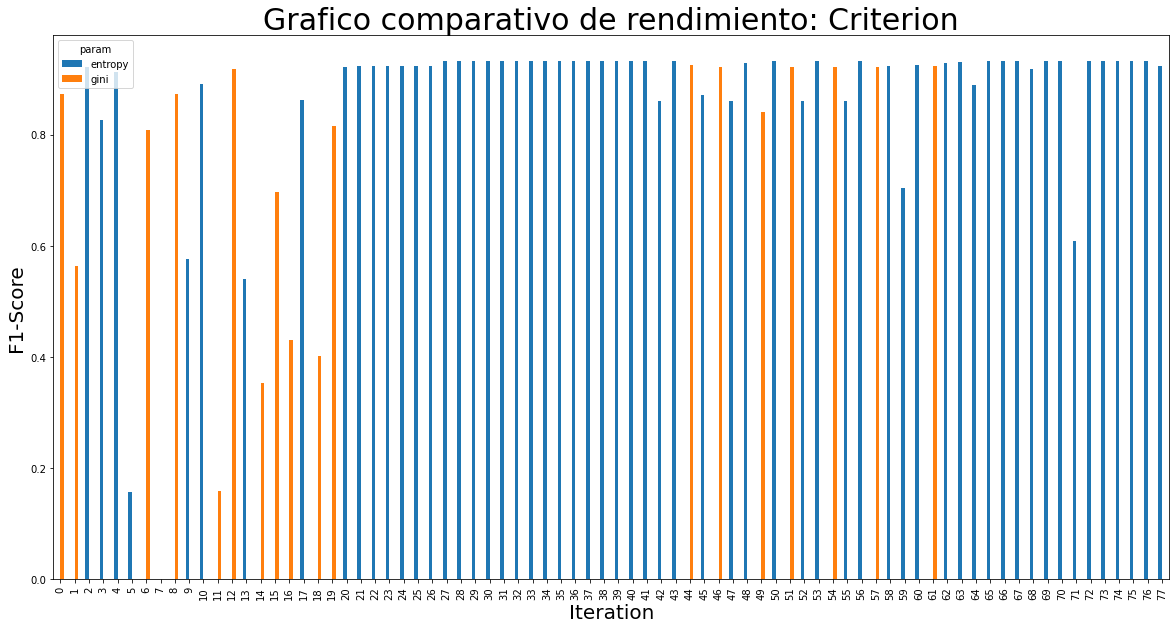

In [12]:
# Gráfico comparativo de rendimiento: Criterion.
import matplotlib.pyplot as plt

df_plot = pd.DataFrame(columns = ['trial', 'param', 'score'])

for scoring in scorings:
    df_plot = df_plot.append({'trial' : scoring['trial'], 
                              'param' : eval(scoring['search_space'])['params']['criterion'], 
                              'score' : scoring['scorings']['F1-Score']},
                             ignore_index = True)

fig = df_plot.pivot(columns = 'param', values ='score').plot(kind = 'bar', 
                                                             figsize = (20, 10), 
                                                             xlabel = 'Iteration', 
                                                             ylabel = 'F1-Score', 
                                                             title = 'Grafico comparativo de rendimiento: Criterion')
fig.xaxis.label.set_size(20)
fig.yaxis.label.set_size(20)
fig.title.set_size(30)

El criterio que clasifica mejor es 'entropy'.

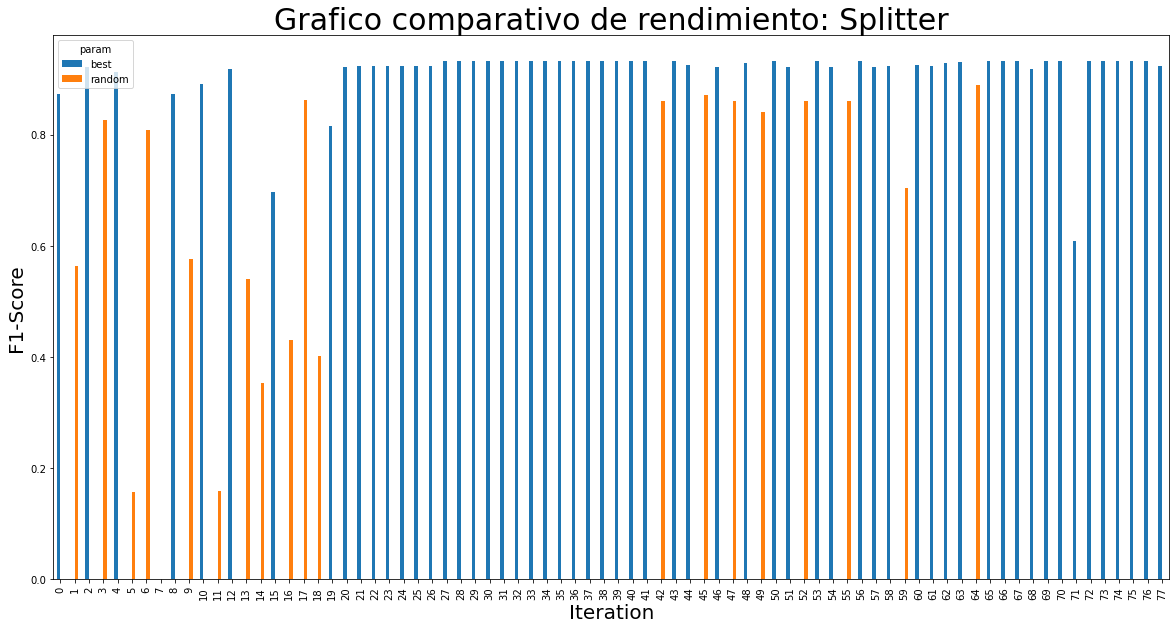

In [13]:
# Gráfico comparativo de rendimiento: Splitter.
import matplotlib.pyplot as plt

df_plot = pd.DataFrame(columns = ['trial', 'param', 'score'])

for scoring in scorings:
    df_plot = df_plot.append({'trial' : scoring['trial'], 
                              'param' : eval(scoring['search_space'])['params']['splitter'], 
                              'score' : scoring['scorings']['F1-Score']},
                             ignore_index = True)

fig = df_plot.pivot(columns = 'param', values ='score').plot(kind = 'bar', 
                                                             figsize = (20, 10), 
                                                             xlabel = 'Iteration', 
                                                             ylabel = 'F1-Score', 
                                                             title = 'Grafico comparativo de rendimiento: Splitter')
fig.xaxis.label.set_size(20)
fig.yaxis.label.set_size(20)
fig.title.set_size(30)

El splitter que clasifica mejor es "best".

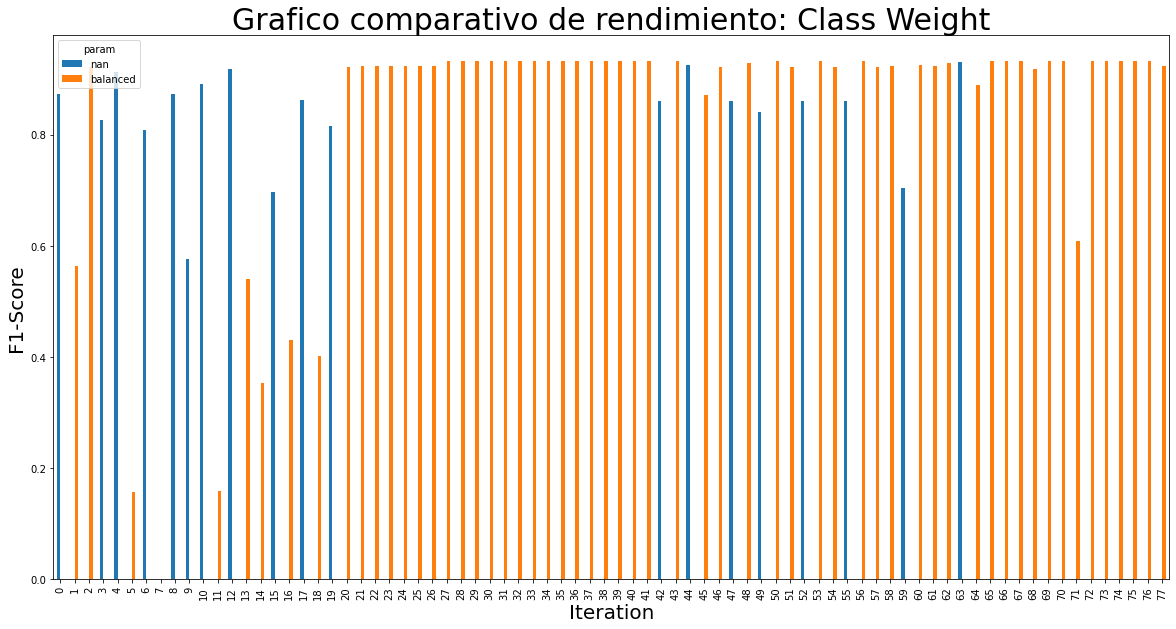

In [14]:
# Gráfico comparativo de rendimiento: Class_Weight.
import matplotlib.pyplot as plt

df_plot = pd.DataFrame(columns = ['trial', 'param', 'score'])

for scoring in scorings:
    df_plot = df_plot.append({'trial' : scoring['trial'], 
                              'param' : eval(scoring['search_space'])['params']['class_weight'], 
                              'score' : scoring['scorings']['F1-Score']},
                             ignore_index = True)

fig = df_plot.pivot(columns = 'param', values ='score').plot(kind = 'bar', 
                                                             figsize = (20, 10), 
                                                             xlabel = 'Iteration', 
                                                             ylabel = 'F1-Score', 
                                                             title = 'Grafico comparativo de rendimiento: Class Weight')
fig.xaxis.label.set_size(20)
fig.yaxis.label.set_size(20)
fig.title.set_size(30)

La consideración de los datos balanceados, mejora la perfomance del modelo.

##### 10.3.2.2. Segunda optimización de hiperparámetros

In [9]:
# Importación de librerías
from sklearn.tree import DecisionTreeClassifier
from math import log

# Definición del espacio / dominio de parámetros.
search_space = {'estimator' : DecisionTreeClassifier(),
                'params' : {'criterion' : hp.choice('criterion', ['entropy']),
                            'splitter' : hp.choice('splitter', ['best']),
                            'max_depth' : hp.qlognormal('max_depth', log(12), log(2), 1),
                            'min_samples_split' : hp.choice('min_samples_split', range(2, 11)),
                            'min_samples_leaf' : hp.choice('min_samples_leaf', range(2, 11)),
                            'class_weight' : hp.choice('class_weight', ['balanced']),
                            'random_state' : 42
                           }
               }
selected_columns = ['isFraud', 'isFlaggedFraud']
X = df_training.drop(labels = selected_columns, axis = 1)
y = df_training['isFraud']
estimator = DecisionTreeClassifier()

# Implementación de Hyperopt
counter = -1
scorings = list()
rstate = np.random.default_rng(42)
trials = Trials() # Para el logging de resultados.
best_params = fmin(fn = objective_func, 
                   space = search_space, 
                   algo = tpe.suggest, 
                   max_evals = 100, 
                   trials = trials, 
                   early_stop_fn = no_progress_loss(50), 
                   rstate = rstate)

# Impresión de resultados.
hyperopt_printer(trials)
json_export(scorings)
scorings_df = scorings_to_df(scorings)

Trial: 0 | Loss: 0.0944 | Elapsed_time: 35.2651 seconds
Trial: 1 | Loss: 0.0692 | Elapsed_time: 37.8180 seconds                           
Trial: 2 | Loss: 0.4670 | Elapsed_time: 35.9888 seconds                             
Trial: 3 | Loss: 0.0724 | Elapsed_time: 35.2747 seconds                             
Trial: 4 | Loss: 0.0739 | Elapsed_time: 34.6586 seconds                           
Trial: 5 | Loss: 0.5975 | Elapsed_time: 34.2132 seconds                           
Trial: 6 | Loss: 0.0793 | Elapsed_time: 34.8067 seconds                           
Trial: 7 | Loss: 0.6238 | Elapsed_time: 32.0686 seconds                           
Trial: 8 | Loss: 0.2781 | Elapsed_time: 39.3442 seconds                           
Trial: 9 | Loss: 0.6238 | Elapsed_time: 32.7272 seconds                           
Trial: 10 | Loss: 0.5971 | Elapsed_time: 34.6069 seconds                           
Trial: 11 | Loss: 0.6883 | Elapsed_time: 24.4908 seconds                           
Trial: 12 | Loss: 0.6238 

##### 10.3.2.3. Tercera optimización de hiperparámetros

In [11]:
# Importación de librerías
from sklearn.tree import DecisionTreeClassifier
from math import log

# Definición del espacio / dominio de parámetros.
search_space = {'estimator' : DecisionTreeClassifier(),
                'params' : {'criterion' : 'entropy',
                            'splitter' : 'best',
                            'max_depth' : hp.randint('max_depth', 5, 50),
                            'min_samples_split' : 4,
                            'min_samples_leaf' : 5,
                            'class_weight' : 'balanced',
                            'random_state' : 42
                           }
               }
selected_columns = ['isFraud', 'isFlaggedFraud']
X = df_training.drop(labels = selected_columns, axis = 1)
y = df_training['isFraud']
estimator = DecisionTreeClassifier()

# Implementación de Hyperopt
counter = -1
scorings = list()
rstate = np.random.default_rng(42)
trials = Trials() # Para el logging de resultados.
best_params = fmin(fn = objective_func, 
                   space = search_space, 
                   algo = tpe.suggest, 
                   max_evals = 100,
                   trials = trials, 
                   early_stop_fn = no_progress_loss(20), 
                   rstate = rstate)

# Impresión de resultados.
hyperopt_printer(trials)
json_export(scorings)
scorings_to_df(scorings)

Trial: 0 | Loss: 0.6194 | Elapsed_time: 36.1730 seconds
Trial: 1 | Loss: 0.0724 | Elapsed_time: 37.5630 seconds                          
Trial: 2 | Loss: 0.2766 | Elapsed_time: 36.9173 seconds                             
Trial: 3 | Loss: 0.0724 | Elapsed_time: 35.3712 seconds                             
Trial: 4 | Loss: 0.0805 | Elapsed_time: 37.0562 seconds                           
Trial: 5 | Loss: 0.0724 | Elapsed_time: 37.5910 seconds                           
Trial: 6 | Loss: 0.0724 | Elapsed_time: 35.6101 seconds                           
Trial: 7 | Loss: 0.0724 | Elapsed_time: 33.3163 seconds                           
Trial: 8 | Loss: 0.6194 | Elapsed_time: 32.4695 seconds                           
Trial: 9 | Loss: 0.0724 | Elapsed_time: 33.3463 seconds                           
Trial: 10 | Loss: 0.5974 | Elapsed_time: 32.9724 seconds                           
Trial: 11 | Loss: 0.0724 | Elapsed_time: 33.2778 seconds                           
Trial: 12 | Loss: 0.0737 |

,Recall,Precision,AUC,Accuracy,Recall_Std,Precision_Std,AUC_Std,Accuracy_Std,F1-Score
0,0.994164,0.244998,0.979235,0.964649,0.003854,0.009460,0.002609,0.001730,0.393038
1,0.926930,0.932340,0.963073,0.998386,0.005471,0.005223,0.002710,0.000046,0.929600
2,0.983506,0.585268,0.987694,0.991784,0.006501,0.014437,0.003064,0.000469,0.733690
3,0.926930,0.932340,0.963073,0.998386,0.005471,0.005223,0.002710,0.000046,0.929600
4,0.933440,0.913866,0.966208,0.998223,0.002844,0.007257,0.001424,0.000100,0.923534
5,0.926930,0.932340,0.963073,0.998386,0.005471,0.005223,0.002710,0.000046,0.929600
6,0.926930,0.932340,0.963073,0.998386,0.005471,0.005223,0.002710,0.000046,0.929600
7,0.926930,0.932340,0.963073,0.998386,0.005471,0.005223,0.002710,0.000046,0.929600
8,0.994164,0.244998,0.979235,0.964649,0.003854,0.009460,0.002609,0.001730,0.393038
9,0.926930,0.932340,0.963073,0.998386,0.005471,0.005223,0.002710,0.000046,0.929600


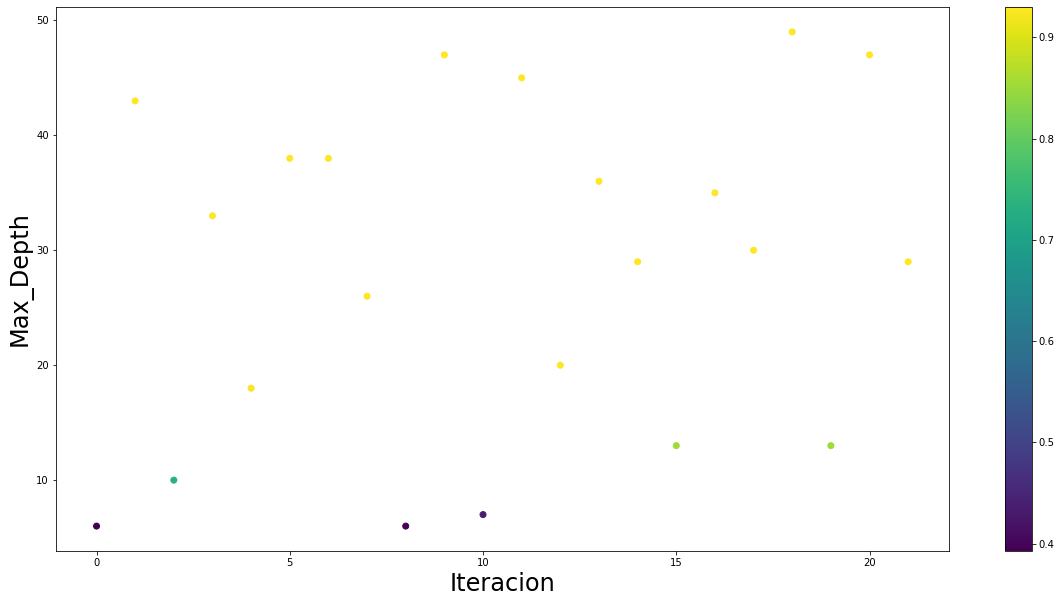

In [34]:
# Representacion grafica de las iteraciones.
import matplotlib.pyplot as plt
max_depth_i = [eval(scoring['search_space'])['params']['max_depth'] for scoring in scorings]
f1 = [scoring['scorings']['F1-Score'] for scoring in scorings]
fig = plt.figure(figsize = (20,10))
fig = plt.scatter(x = range(len(max_depth_i)), y = max_depth_i, c = f1)
fig = plt.xlabel('Iteracion', size = 24)
fig = plt.ylabel('Max_Depth', size = 24)
fig = plt.colorbar()

##### 10.3.2.4. Evaluación de perfomance con el conjunto de validación

Best Trial:
Trial ID : 1
Loss : 0.07240180145225181
Params : {'estimator': DecisionTreeClassifier(), 'params': {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 43, 'min_samples_leaf': 5, 'min_samples_split': 4, 'random_state': 42, 'splitter': 'best'}}

|--- oldbalanceOrig <= 54380.11
|   |--- amount <= 53782.88
|   |   |--- Payment <= 0.50
|   |   |   |--- oldbalanceOrig <= 118.50
|   |   |   |   |--- amount <= 63.84
|   |   |   |   |   |--- amount <= 0.82
|   |   |   |   |   |   |--- weights: [0.00, 956.69] class: 1
|   |   |   |   |   |--- amount >  0.82
|   |   |   |   |   |   |--- truncated branch of depth 3
|   |   |   |   |--- amount >  63.84
|   |   |   |   |   |--- idOrig <= 296697.50
|   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |--- idOrig >  296697.50
|   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |--- oldbalanceOrig >  118.50
|   |   |   |   |--- newbalanceOrig <= 1.32
|   |   |   |   |   |--- newbalanceDest <= 848.25
|   |   |   |   |   |   |--- truncated branch of depth 11
|   |   |   |   |   |--- newbalanceDest >  848.25
|   |   |   |   |   |   |--- truncated branch of depth 18
|   |   |   |   |--- newbalanceOrig >  1.32
|   |   |   |   |   |--- weights: [11022.23, 0

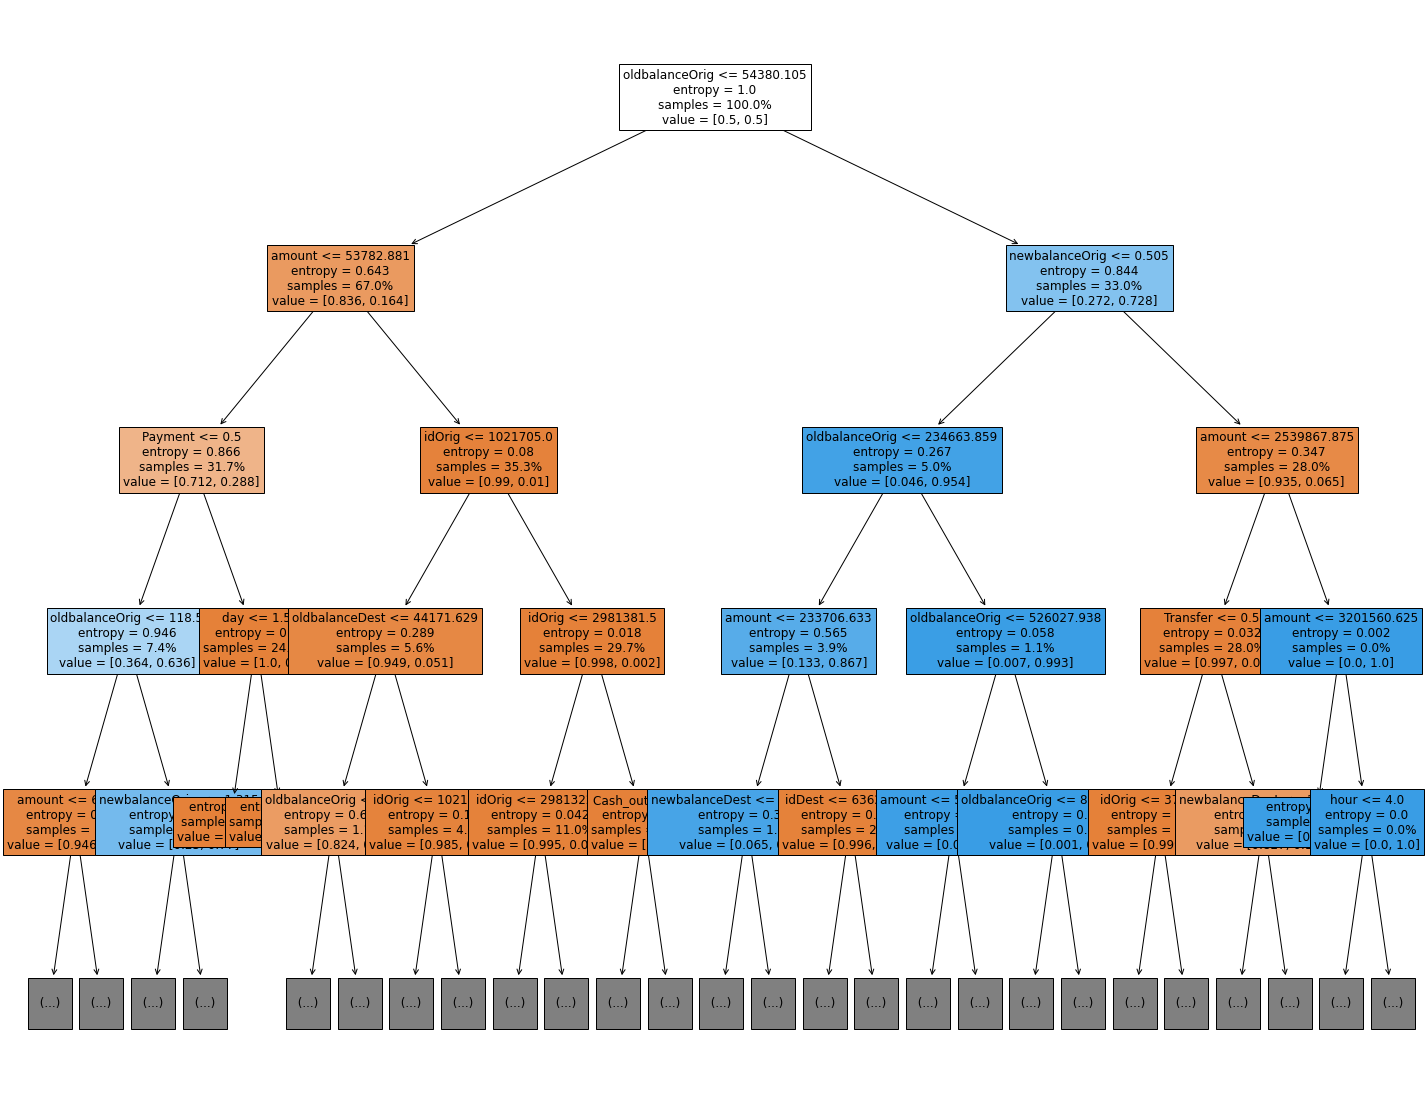

In [14]:
# Representación gráfica
# https://mljar.com/blog/visualize-decision-tree/

import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree

params = {'class_weight' : 'balanced',
          'criterion' : 'entropy',
          'max_depth' : 43, 
          'min_samples_leaf' : 5, 
          'min_samples_split' : 4, 
          'random_state' : 42,
          'splitter' : 'best'}

selected_columns = ['isFraud', 'isFlaggedFraud']
X_train = df_training.drop(labels = selected_columns, axis = 1)
y_train = df_training['isFraud']

clf = DecisionTreeClassifier(**params)
clf.fit(X = X_train.loc[balancing(X_train, y_train, 0.8), :], y = y_train.loc[balancing(X_train, y_train, 0.8)])

text_representation = export_text(clf, show_weights = True, max_depth = 5, feature_names = list(X_train.columns))
print(text_representation)

fig = plt.figure(figsize=(25,20))
fig = plot_tree(clf, max_depth = 4, fontsize = 12, feature_names = X_train.columns, proportion = True, filled = True)

In [15]:
# Weights de los atributos.
print(pd.DataFrame(data = (X_train.columns, clf.feature_importances_)).transpose().sort_values(1, ascending = False))

                 0         1
5   newbalanceOrig  0.358996
4   oldbalanceOrig   0.31545
2           amount  0.185852
12         Payment  0.098289
8   newbalanceDest  0.016583
3           idOrig  0.013737
13        Transfer  0.003478
7   oldbalanceDest  0.003082
6           idDest  0.002314
10        Cash_out  0.001646
1             hour  0.000498
0              day  0.000076
9          Cash_in       0.0
11           Debit       0.0


Recall: 0.9519
Precision: 0.6216
AUC: 0.9756
Accuracy: 0.9992
F1-Score: 0.7521


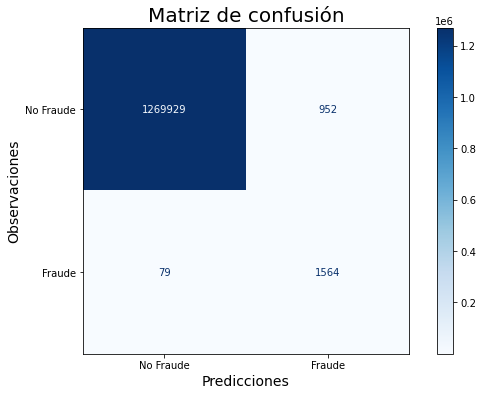

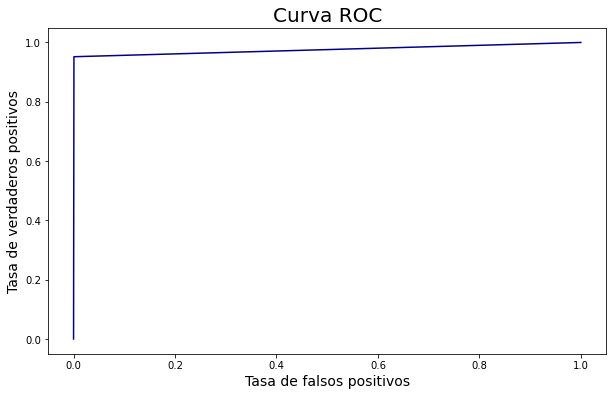

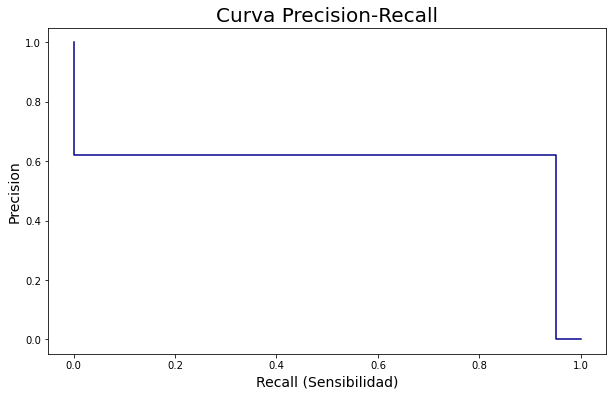

In [17]:
# Evaluación con el conjunto de validación.
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score

X_test = df_validation.drop(labels = selected_columns, axis = 1)
y_test = df_validation['isFraud']

y_pred = clf.predict(X_test)

print('Recall: %.4f' % recall_score(y_true = y_test, y_pred = y_pred))
print('Precision: %.4f' % precision_score(y_true = y_test, y_pred = y_pred))
print('AUC: %.4f' % roc_auc_score(y_true = y_test, y_score = y_pred))
print('Accuracy: %.4f' % accuracy_score(y_true = y_test, y_pred = y_pred))
print('F1-Score: %.4f' % f1_score(y_true = y_test, y_pred = y_pred))

# # Exportación de gráficos.
from export import export_png_2
export_png_2(filename = 'decisiontree_balanced', y_test = y_test, y_pred = y_pred)

#### 10.3.3. SVM

Se evaluaron diversos modelos de clasificación de tipo SVM. De los resultados obtenidos, se decide utilizar el modelo LinearSVC por ofrecer el mejor rendimiento.

##### 10.3.3.1. Ingeniería de predictores Nro. 1

Se evalua la eliminación de algunos atributos (día y hora de la operación y códigos de identificación de originante y destinatario, en estos dos últimos casos considerando la naturaleza del modelo).

In [7]:
# Combinaciones de columnas.
import itertools

items =  ['day', 'hour', 'idOrig', 'oldbalanceOrig', 'newbalanceOrig', 
          'idDest', 'oldbalanceDest', 'newbalanceDest']

combinations = []
for item in range(0, len(items) + 1):
    for subset in itertools.combinations(items, item):
        combinations.append(list(subset))

In [8]:
%%time
# Ejecución del optimizador de ingeniería de predictores.
from sklearn.model_selection import StratifiedKFold, cross_validate, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, f1_score
from sklearn.svm import LinearSVC
from joblib import Parallel, delayed

sss = StratifiedShuffleSplit(n_splits = 1, train_size = 0.1, random_state = 42)

for a, b in sss.split(df_training, y = df_training['isFraud']):
    X = df_training.iloc[a,:-2]
    y = df_training.iloc[a,:]['isFraud']

def eval_combination(combination):
    
    counter = 0
    start_time = time.time()    
    
    X_dropped = X.drop(combination, axis = 1)
    
    estimator = LinearSVC(random_state = 42)
    skf = StratifiedKFold(random_state = 42, n_splits = 4, shuffle = True)
    
    scores = {'Recall': [],
              'Precision': [],
              'AUC': [],
              'Accuracy': [],
              'F1-Score': []
             }
    
    for train, test in skf.split(X = X_dropped, y = y):
        
        X_train = X_dropped.iloc[train, :]
        X_test = X_dropped.iloc[test, :]
        y_train = y.iloc[train]
        y_test = y.iloc[test]

        indexes_train = balancing(X_train, y_train, 0.8)
        indexes_test = balancing(X_test, y_test, 0.8)

        X_train = X_train.loc[indexes_train, :]
        X_test = X_test.loc[indexes_test, :]
        y_train = y_train.loc[indexes_train]
        y_test = y_test.loc[indexes_test]
        
        estimator.fit(X_train, y_train)
        y_pred = estimator.predict(X_test)
        
        scores['Recall'].append(recall_score(y_test, y_pred))
        scores['Precision'].append(precision_score(y_test, y_pred))
        scores['AUC'].append(roc_auc_score(y_test, y_pred))
        scores['Accuracy'].append(accuracy_score(y_test, y_pred))
        scores['F1-Score'].append(f1_score(y_test, y_pred))
    
    loss = 1 - np.mean(scores['F1-Score']) + np.std(scores['F1-Score'])
    elapsed_time = time.time() - start_time
    
    return combination, loss, elapsed_time, scores
    
results = Parallel(n_jobs = -1, verbose = 100)(delayed(eval_combination)(combination) for combination in combinations)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  3

In [20]:
# Almacenamiento de resultados en variable scorings.
scorings = []
counter = 0

for result in results:    
    scorings.append({'trial': counter,
                     'search_space' : result[0],
                     'scorings' : {'Recall': np.mean(result[3]['Recall']),
                                   'Precision': np.mean(result[3]['Precision']),
                                   'AUC': np.mean(result[3]['AUC']),
                                   'Accuracy': np.mean(result[3]['Accuracy']),
                                   'Recall_Std': np.std(result[3]['Recall']),
                                   'Precision_Std': np.std(result[3]['Precision']),
                                   'AUC_Std': np.std(result[3]['AUC']),
                                   'Accuracy_Std': np.std(result[3]['Accuracy']),
                                   'F1-Score': np.mean(result[3]['F1-Score'])}
                    }
                   )
    counter += 1

In [25]:
# Impresión de reportes.
json_export(scorings)
scorings_df = scorings_to_df(scorings)

Json file: 20220518_174050.json

Scoring details:

       Recall  Precision       AUC  Accuracy  Recall_Std  Precision_Std   AUC_Std  Accuracy_Std  F1-Score
0    0.440818   0.957921  0.720296  0.993350    0.014353       0.018124  0.007186      0.000222  0.603637
1    0.440818   0.957921  0.720296  0.993350    0.014353       0.018124  0.007186      0.000222  0.603637
2    0.440818   0.957921  0.720296  0.993350    0.014353       0.018124  0.007186      0.000222  0.603637
3    0.431541   0.947097  0.715608  0.993145    0.051057       0.045938  0.025363      0.000281  0.589400
4    0.257456   0.563050  0.605643  0.945823    0.195119       0.328033  0.059250      0.075651  0.197844
5    0.072744   0.827110  0.536254  0.989110    0.033992       0.100633  0.016924      0.000249  0.130644
6    0.463773   0.402612  0.718957  0.968274    0.315597       0.371727  0.153091      0.037196  0.338954
7    0.494099   0.897040  0.746695  0.993486    0.038369       0.065206  0.019086      0.000557  0.63

In [26]:
# Ordenamiento de scorings.
scorings_df.sort_values(by = 'F1-Score', axis = 0, ascending = False)

,Recall,Precision,AUC,Accuracy,Recall_Std,Precision_Std,AUC_Std,Accuracy_Std,F1-Score
192,0.923104,0.670794,0.958527,0.993136,0.032349,0.140980,0.014902,0.003179,0.766275
228,0.917991,0.686164,0.955513,0.992173,0.031542,0.205212,0.014367,0.006757,0.764160
157,0.948374,0.646637,0.970798,0.992708,0.011898,0.137231,0.006045,0.003536,0.760852
60,0.799426,0.674672,0.897313,0.992951,0.080112,0.118489,0.040654,0.002860,0.727727
95,0.726471,0.623252,0.859921,0.990306,0.145786,0.212506,0.071794,0.004410,0.645614
...,...,...,...,...,...,...,...,...,...
217,0.001695,0.000111,0.471049,0.929615,0.002936,0.000192,0.034863,0.071597,0.000208
180,0.000000,0.000000,0.487887,0.964560,0.000000,0.000000,0.008884,0.017557,0.000000
247,0.000000,0.000000,0.500000,0.988508,0.000000,0.000000,0.000000,0.000033,0.000000
219,0.000000,0.000000,0.499326,0.987175,0.000000,0.000000,0.000883,0.001741,0.000000


In [27]:
# Impresion de mejor combinacion de atributos
print('Mejor combinacion de atributos a eliminar: ', *combinations[192])

Mejor combinacion de atributos a eliminar:  day idOrig idDest oldbalanceDest newbalanceDest


##### 10.3.3.2. Ingeniería de predictores Nro. 2

Se evalua el impacto de la aplicación de distintos métodos de estandarización de atributos.

Escalamiento de atributos a un mínimo de 0 y máximo de 1.

Se eliminan las columnas 'day', 'idOrig', 'idDest', 'oldbalanceDest' y 'newbalanceDest'.

In [57]:
%%time
# Ejecución del optimizador de ingeniería de predictores.
from sklearn.model_selection import StratifiedKFold, cross_validate, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, f1_score
from sklearn.svm import LinearSVC
from joblib import Parallel, delayed
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler, RobustScaler

sss = StratifiedShuffleSplit(n_splits = 1, train_size = 0.5, random_state = 42)

for a, b in sss.split(df_training, y = df_training['isFraud']):
    X = df_training.iloc[a,:-2]
    y = df_training.iloc[a,:]['isFraud']

selected_columns = ['day', 'idOrig', 'idDest', 'oldbalanceDest', 'newbalanceDest']
scalers = [None, MinMaxScaler((0, 1)), MinMaxScaler((-1, 1)), MaxAbsScaler(), StandardScaler(), RobustScaler()]

X = X.drop(selected_columns, axis = 1)
    
def eval_scaler(scaler):
    
    start_time = time.time()
    
    if scaler is not None:
        X_ = scaler.fit_transform(X)
        X_ = pd.DataFrame(X_)
        X_.index = X.index
    else:
        X_ = X
    
    estimator = LinearSVC(random_state = 42)
    skf = StratifiedKFold(random_state = 42, n_splits = 4, shuffle = True)
    
    scores = {'Recall': [],
              'Precision': [],
              'AUC': [],
              'Accuracy': [],
              'F1-Score': []
             }
    
    for train, test in skf.split(X = X_, y = y):
        
        X_train = X_.iloc[train, :]
        X_test = X_.iloc[test, :]
        y_train = y.iloc[train]
        y_test = y.iloc[test]
        
        indexes_train = balancing(X_train, y_train, 0.8)
        indexes_test = balancing(X_test, y_test, 0.8)

        X_train = X_train.loc[indexes_train, :]
        X_test = X_test.loc[indexes_test, :]
        y_train = y_train.loc[indexes_train]
        y_test = y_test.loc[indexes_test]
        
        estimator.fit(X_train, y_train)
        y_pred = estimator.predict(X_test)
        
        scores['Recall'].append(recall_score(y_test, y_pred))
        scores['Precision'].append(precision_score(y_test, y_pred))
        scores['AUC'].append(roc_auc_score(y_test, y_pred))
        scores['Accuracy'].append(accuracy_score(y_test, y_pred))
        scores['F1-Score'].append(f1_score(y_test, y_pred))
    
    loss = 1 - np.mean(scores['F1-Score']) + np.std(scores['F1-Score'])
    elapsed_time = time.time() - start_time
    
    return scaler, loss, elapsed_time, scores
    
results = Parallel(n_jobs = -1, verbose = 100)(delayed(eval_scaler)(scaler) for scaler in scalers)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:   26.0s remaining:   52.1s
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:   59.2s remaining:   59.2s
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:  1.6min remaining:   48.4s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  3.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  3.2min finished
Wall time: 3min 17s


In [58]:
# Almacenamiento de resultados en variable scorings.
scorings = []
counter = 0

for result in results:    
    scorings.append({'trial': counter,
                     'search_space' : result[0],
                     'scorings' : {'Recall': np.mean(result[3]['Recall']),
                                   'Precision': np.mean(result[3]['Precision']),
                                   'AUC': np.mean(result[3]['AUC']),
                                   'Accuracy': np.mean(result[3]['Accuracy']),
                                   'Recall_Std': np.std(result[3]['Recall']),
                                   'Precision_Std': np.std(result[3]['Precision']),
                                   'AUC_Std': np.std(result[3]['AUC']),
                                   'Accuracy_Std': np.std(result[3]['Accuracy']),
                                   'F1-Score': np.mean(result[3]['F1-Score'])}
                    }
                   )
    counter += 1

In [60]:
# Impresión de reportes.
# json_export(scorings)
scorings_df = scorings_to_df(scorings)

Scoring details:

     Recall  Precision       AUC  Accuracy  Recall_Std  Precision_Std   AUC_Std  Accuracy_Std  F1-Score
0  0.931843   0.241681  0.937296  0.942622    0.058362       0.144284  0.025188      0.045982  0.361633
1  0.263276   0.990743  0.631623  0.991504    0.011910       0.007148  0.005946      0.000116  0.415828
2  0.352115   0.984005  0.676024  0.992488    0.007882       0.006139  0.003937      0.000087  0.518578
3  0.263276   0.990743  0.631623  0.991504    0.011910       0.007148  0.005946      0.000116  0.415828
4  0.463115   0.324973  0.725915  0.982674    0.004296       0.025370  0.002197      0.001289  0.381362
5  0.511170   0.934804  0.755378  0.993972    0.009419       0.006068  0.004696      0.000092  0.660856


In [61]:
# Ordenamiento de scorings.
scorings_df.sort_values(by = 'F1-Score', axis = 0, ascending = False)

,Recall,Precision,AUC,Accuracy,Recall_Std,Precision_Std,AUC_Std,Accuracy_Std,F1-Score
5,0.511170,0.934804,0.755378,0.993972,0.009419,0.006068,0.004696,0.000092,0.660856
2,0.352115,0.984005,0.676024,0.992488,0.007882,0.006139,0.003937,0.000087,0.518578
1,0.263276,0.990743,0.631623,0.991504,0.011910,0.007148,0.005946,0.000116,0.415828
3,0.263276,0.990743,0.631623,0.991504,0.011910,0.007148,0.005946,0.000116,0.415828
4,0.463115,0.324973,0.725915,0.982674,0.004296,0.025370,0.002197,0.001289,0.381362
0,0.931843,0.241681,0.937296,0.942622,0.058362,0.144284,0.025188,0.045982,0.361633


In [63]:
# Impresion de mejor método de normalización de atributos
print('Mejor método de normalización de atributos a eliminar: ', scalers[5])

Mejor método de normalización de atributos a eliminar:  RobustScaler()


El método de estandarización RobustScaler parecería producir mejores resultados que con el dataset original.

##### 10.3.3.3. Primera optimización de hiperparámetros

Se evaluan hiperparámetros del modelo.

Penalty L1 no se considera ya que arroja valores nulos como resultado.

In [85]:
# Importación de librerías
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold, cross_validate, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, f1_score
from sklearn.preprocessing import RobustScaler
from math import log

# Ingeniería de predictores
selected_columns = ['day', 'idOrig', 'idDest', 'oldbalanceDest', 'newbalanceDest']
scaler = RobustScaler()
sss = StratifiedShuffleSplit(n_splits = 1, train_size = 0.2, random_state = 42)

for a, b in sss.split(df_training, y = df_training['isFraud']):
    X = df_training.iloc[a,:-2]
    y = df_training.iloc[a,:]['isFraud']

index = X.index
X = X.drop(selected_columns, axis = 1)
X = scaler.fit_transform(X)
X = pd.DataFrame(X)
X.index = index

# Definición del espacio / dominio de parámetros.
estimator = LinearSVC()
search_space = {'params' : {'penalty' : 'l2',
                            'loss' : hp.choice('loss', ['hinge', 'squared_hinge']),
                            'C' : hp.lognormal('C', log(1.01), log(1.01)),
                            'random_state' : 42
                            }
               }

# Implementación de Hyperopt
counter = -1
scorings = list()
rstate = np.random.default_rng(42)
trials = Trials() # Para el logging de resultados.
best_params = fmin(fn = objective_func, 
                   space = search_space, 
                   algo = tpe.suggest, 
                   max_evals = 100, 
                   trials = trials, 
                   early_stop_fn = no_progress_loss(20), 
                   rstate = rstate)

# Impresión de resultados.
hyperopt_printer(trials)
json_export(scorings)
scorings_df = scorings_to_df(scorings)

Trial: 0 | Loss: 0.3599 | Elapsed_time: 8.1462 seconds 
Trial: 1 | Loss: 0.3565 | Elapsed_time: 18.4533 seconds                          
Trial: 2 | Loss: 0.3573 | Elapsed_time: 7.2148 seconds                           
Trial: 3 | Loss: 0.3600 | Elapsed_time: 17.5103 seconds                         
Trial: 4 | Loss: 0.3584 | Elapsed_time: 7.6426 seconds                          
Trial: 5 | Loss: 0.3574 | Elapsed_time: 18.8334 seconds                         
Trial: 6 | Loss: 0.3600 | Elapsed_time: 18.4898 seconds                         
Trial: 7 | Loss: 0.3586 | Elapsed_time: 7.0292 seconds                          
Trial: 8 | Loss: 0.3595 | Elapsed_time: 7.1449 seconds                          
Trial: 9 | Loss: 0.3637 | Elapsed_time: 18.4806 seconds                         
Trial: 10 | Loss: 0.3503 | Elapsed_time: 7.2642 seconds                          
Trial: 11 | Loss: 0.3571 | Elapsed_time: 18.6126 seconds                          
Trial: 12 | Loss: 0.3604 | Elapsed_time: 7.7134 

##### 10.3.3.4. Segunda optimización de hiperparámetros

Best Trial:
Trial ID : 10
Loss : 0.3503396981501966
Params : {'params': {'C': 1.0026895733272085, 'loss': 'hinge', 'penalty': 'l2', 'random_state': 42}}

In [88]:
# Importación de librerías
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold, cross_validate, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, f1_score
from sklearn.preprocessing import RobustScaler
from math import log

# Ingeniería de predictores
selected_columns = ['day', 'idOrig', 'idDest', 'oldbalanceDest', 'newbalanceDest']
scaler = RobustScaler()
sss = StratifiedShuffleSplit(n_splits = 1, train_size = 0.2, random_state = 42)

for a, b in sss.split(df_training, y = df_training['isFraud']):
    X = df_training.iloc[a,:-2]
    y = df_training.iloc[a,:]['isFraud']

index = X.index
X = X.drop(selected_columns, axis = 1)
X = scaler.fit_transform(X)
X = pd.DataFrame(X)
X.index = index

# Definición del espacio / dominio de parámetros.
estimator = LinearSVC()
search_space = {'estimator' : LinearSVC(),
                'params' : {'penalty' : 'l2',
                            'loss' : 'hinge',
                            'C' : 1.0026895733272085,
                            'random_state' : 42,
                            # 'dual' : hp.choice('dual', [True, False]),
                            'tol' : hp.normal('tol', 0.0001, 0.00001),
                            'fit_intercept' : hp.choice('fit_intercept', [True, False]),
                            'intercept_scaling' : hp.normal('intercept_scaling', 1, 0.01),
                            'class_weight' : hp.choice('class_weight', ['balanced', None]),
                            'max_iter' : hp.randint('max_iter', 10, 2000)
                            }
               }

# Implementación de Hyperopt
counter = -1
scorings = list()
rstate = np.random.default_rng(42)
trials = Trials() # Para el logging de resultados.
best_params = fmin(fn = objective_func, 
                   space = search_space, 
                   algo = tpe.suggest, 
                   max_evals = 100, 
                   trials = trials, 
                   early_stop_fn = no_progress_loss(50), 
                   rstate = rstate)

# Impresión de resultados.
hyperopt_printer(trials)
json_export(scorings)
scorings_df = scorings_to_df(scorings)

Trial: 0 | Loss: 0.7411 | Elapsed_time: 19.7358 seconds
Trial: 1 | Loss: 0.3588 | Elapsed_time: 5.1627 seconds                           
Trial: 2 | Loss: 0.3538 | Elapsed_time: 7.7092 seconds                            
Trial: 3 | Loss: 0.6682 | Elapsed_time: 9.2416 seconds                            
Trial: 4 | Loss: 0.7422 | Elapsed_time: 17.3802 seconds                           
Trial: 5 | Loss: 0.3575 | Elapsed_time: 7.3846 seconds                            
Trial: 6 | Loss: 0.6130 | Elapsed_time: 4.8274 seconds                            
Trial: 7 | Loss: 0.7468 | Elapsed_time: 22.7816 seconds                           
Trial: 8 | Loss: 0.7284 | Elapsed_time: 12.6147 seconds                           
Trial: 9 | Loss: 0.8396 | Elapsed_time: 16.6428 seconds                           
Trial: 10 | Loss: 0.7403 | Elapsed_time: 20.6982 seconds                           
Trial: 11 | Loss: 0.3628 | Elapsed_time: 4.8800 seconds                            
Trial: 12 | Loss: 0.7276 | Ela

##### 10.3.3.5. Evaluación sobre el conjunto de validación

Best Trial:
Trial ID : 67
Loss : 0.29665156141281057
Params : {'estimator': LinearSVC(), 'params': {'C': 1.0026895733272085, 'class_weight': None, 'fit_intercept': True, 'intercept_scaling': 1.013090208053348, 'loss': 'hinge', 'max_iter': 28, 'penalty': 'l2', 'random_state': 42, 'tol': 9.570017427461634e-05}}

In [10]:
# Evaluación con el conjunto de validación.
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import RobustScaler
from sklearn.svm import LinearSVC

# Espacio de parámetros.
params = {'C': 1.0026895733272085, 
          'class_weight': None, 
          'fit_intercept': True, 
          'intercept_scaling': 1.013090208053348, 
          'loss': 'hinge', 
          'max_iter': 28, 
          'penalty': 'l2', 
          'random_state': 42, 
          'tol': 9.570017427461634e-05}

# Ingeniería de predictores.
selected_columns = ['day', 'idOrig', 'idDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']
scaler = RobustScaler()

X_train = df_training.drop(selected_columns, axis = 1)
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train)
X_train.index = df_training.index
y_train = df_training['isFraud']

X_test = df_validation.drop(selected_columns, axis = 1)
X_test = scaler.fit_transform(X_test)
y_test = df_validation['isFraud']

# Balanceo de datos.
indexes = balancing(X_train, y_train, 0.8)
X_balanced = X_train.loc[indexes, :]
y_balanced = y_train.loc[indexes]

# Entrenamiento del modelo.
clf = LinearSVC(**params)
clf.fit(X = X_balanced, y = y_balanced)

# Aplicación del modelo entrenado sobre el conjunto de validación.
y_pred = clf.predict(X_test)

# Obtención de métricas.
print('Recall: %.4f' % recall_score(y_true = y_test, y_pred = y_pred))
print('Precision: %.4f' % precision_score(y_true = y_test, y_pred = y_pred))
print('AUC: %.4f' % roc_auc_score(y_true = y_test, y_score = y_pred))
print('Accuracy: %.4f' % accuracy_score(y_true = y_test, y_pred = y_pred))
print('F1-Score: %.4f' % f1_score(y_true = y_test, y_pred = y_pred))

Recall: 0.5338
Precision: 0.7929
AUC: 0.7668
Accuracy: 0.9992
F1-Score: 0.6381


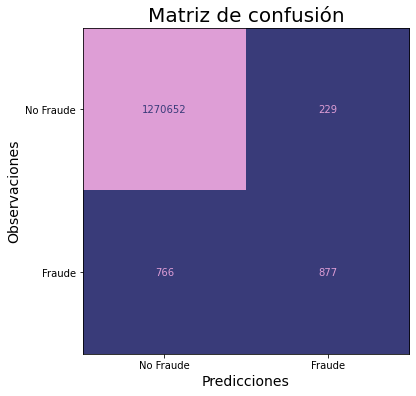

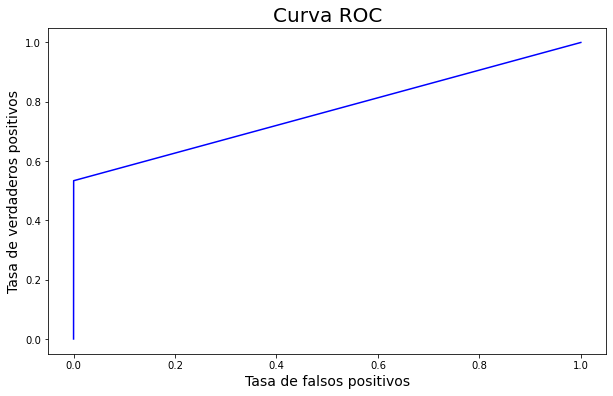

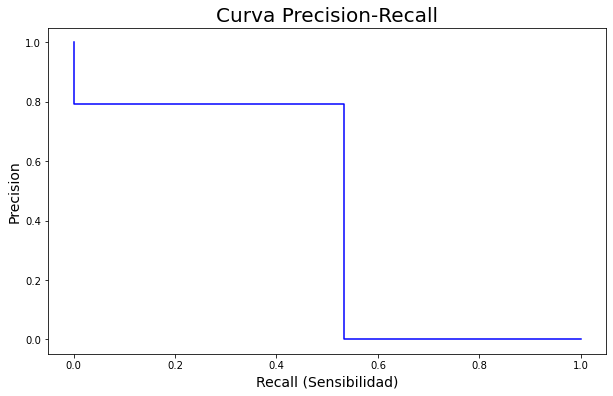

In [12]:
# Exportación a png.
from export import export_png
export_png(filename = 'svm_balanced', y_test = y_test, y_pred = y_pred)

#### 10.3.4. Redes neuronales

##### 10.3.4.1. Ingeniería de predictores Nro. 1

Se evalua la eliminación de algunos atributos (día y hora de la operación y códigos de identificación de originante y destinatario, en estos dos últimos casos considerando la naturaleza del modelo).

In [91]:
# Combinaciones de columnas.
import itertools

items =  ['day', 'hour', 'idOrig', 'oldbalanceOrig', 'newbalanceOrig', 
          'idDest', 'oldbalanceDest', 'newbalanceDest']

combinations = []
for item in range(0, len(items) + 1):
    for subset in itertools.combinations(items, item):
        combinations.append(list(subset))

In [99]:
%%time
# Ejecución del optimizador de ingeniería de predictores.
from sklearn.model_selection import StratifiedKFold, cross_validate, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, f1_score
from sklearn.neural_network import MLPClassifier
from joblib import Parallel, delayed

sss = StratifiedShuffleSplit(n_splits = 1, train_size = 0.05, random_state = 42)

for a, b in sss.split(df_training, y = df_training['isFraud']):
    X = df_training.iloc[a,:-2]
    y = df_training.iloc[a,:]['isFraud']

def eval_combination(combination):
    
    start_time = time.time()
    
    counter = 0
    scores = {'Recall': [],
              'Precision': [],
              'AUC': [],
              'Accuracy': [],
              'F1-Score': []
             }
    
    X_dropped = X.drop(combination, axis = 1)

    estimator = MLPClassifier(random_state = 42)
    skf = StratifiedKFold(random_state = 42, n_splits = 4, shuffle = True)
    
    for train, test in skf.split(X = X_dropped, y = y):
        
        X_train = X_dropped.iloc[train, :]
        X_test = X_dropped.iloc[test, :]
        y_train = y.iloc[train]
        y_test = y.iloc[test]

        indexes_train = balancing(X_train, y_train, 0.8)
        indexes_test = balancing(X_test, y_test, 0.8)

        X_train = X_train.loc[indexes_train, :]
        X_test = X_test.loc[indexes_test, :]
        y_train = y_train.loc[indexes_train]
        y_test = y_test.loc[indexes_test]
        
        estimator.fit(X_train, y_train)
        y_pred = estimator.predict(X_test)
        
        scores['Recall'].append(recall_score(y_test, y_pred))
        scores['Precision'].append(precision_score(y_test, y_pred))
        scores['AUC'].append(roc_auc_score(y_test, y_pred))
        scores['Accuracy'].append(accuracy_score(y_test, y_pred))
        scores['F1-Score'].append(f1_score(y_test, y_pred))
    
    loss = 1 - np.mean(scores['F1-Score']) + np.std(scores['F1-Score'])
    elapsed_time = time.time() - start_time
    
    return combination, loss, elapsed_time, scores
    
results = Parallel(n_jobs = -1, verbose = 100)(delayed(eval_combination)(combination) for combination in combinations)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   40.3s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   40.3s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   45.7s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   47.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   55.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   56.9s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  1

In [100]:
# Almacenamiento de resultados en variable scorings.
scorings = []
counter = 0

for result in results:    
    scorings.append({'trial': counter,
                     'search_space' : result[0],
                     'scorings' : {'Recall': np.mean(result[3]['Recall']),
                                   'Precision': np.mean(result[3]['Precision']),
                                   'AUC': np.mean(result[3]['AUC']),
                                   'Accuracy': np.mean(result[3]['Accuracy']),
                                   'Recall_Std': np.std(result[3]['Recall']),
                                   'Precision_Std': np.std(result[3]['Precision']),
                                   'AUC_Std': np.std(result[3]['AUC']),
                                   'Accuracy_Std': np.std(result[3]['Accuracy']),
                                   'F1-Score': np.mean(result[3]['F1-Score'])}
                    }
                   )
    counter += 1

In [101]:
# Impresión de reportes.
json_export(scorings)
scorings_df = scorings_to_df(scorings)

Json file: 20220518_214311.json

Scoring details:

       Recall  Precision       AUC  Accuracy  Recall_Std  Precision_Std   AUC_Std  Accuracy_Std  F1-Score
0    0.760204   0.632006  0.877181  0.991482    0.091821       0.111799  0.044901      0.002945  0.677661
1    0.537415   0.903557  0.768206  0.993718    0.114338       0.124828  0.056637      0.000926  0.655620
2    0.673469   0.795166  0.835328  0.993485    0.141146       0.159862  0.069436      0.001330  0.700333
3    0.654762   0.825199  0.826378  0.994068    0.105866       0.133252  0.052399      0.001385  0.715126
4    0.289116   0.692271  0.643515  0.989809    0.062810       0.181847  0.030611      0.000919  0.389066
5    0.537415   0.760925  0.767704  0.992727    0.069207       0.112140  0.035042      0.001761  0.629111
6    0.739796   0.579093  0.866160  0.989634    0.084334       0.149186  0.040594      0.003619  0.630554
7    0.755102   0.593326  0.874472  0.991112    0.065779       0.060627  0.032474      0.001437  0.66

In [102]:
# Ordenamiento de scorings.
scorings_df.sort_values(by = 'F1-Score', axis = 0, ascending = False)

,Recall,Precision,AUC,Accuracy,Recall_Std,Precision_Std,AUC_Std,Accuracy_Std,F1-Score
157,0.896259,0.715237,0.945257,0.993135,0.093568,0.184607,0.044755,0.004644,0.770557
20,0.705782,0.849790,0.851976,0.994827,0.100484,0.119877,0.049434,0.000693,0.756413
70,0.777211,0.746613,0.886855,0.993991,0.100599,0.120273,0.049962,0.002537,0.751408
14,0.726190,0.844503,0.861433,0.993582,0.133251,0.225779,0.064438,0.004130,0.740679
21,0.619048,0.917521,0.809180,0.994963,0.041935,0.048652,0.020786,0.000336,0.736995
...,...,...,...,...,...,...,...,...,...
241,0.000000,0.000000,0.500000,0.988565,0.000000,0.000000,0.000000,0.000000,0.000000
152,0.000000,0.000000,0.498072,0.984753,0.000000,0.000000,0.002372,0.004690,0.000000
253,0.000000,0.000000,0.499990,0.988545,0.000000,0.000000,0.000017,0.000034,0.000000
254,0.000000,0.000000,0.499990,0.988545,0.000000,0.000000,0.000017,0.000034,0.000000


In [103]:
# Impresion de mejor combinacion de atributos
print('Mejor combinacion de atributos a eliminar: ', *combinations[157])

Mejor combinacion de atributos a eliminar:  idOrig idDest oldbalanceDest newbalanceDest


De la lectura de los scorings y observando que eliminación de columnas produce mejores resultados, se decide eliminar: "idOrig", idDest", "oldbalanceDest", "newbalanceDest".

##### 10.3.4.2. Ingeniería de predictores Nro. 2

Se procede a optimizar el criterio de transformación de las dimensiones del dataset.

In [104]:
%%time
# Ejecución del optimizador de ingeniería de predictores.
from sklearn.model_selection import StratifiedKFold, cross_validate, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, f1_score
from sklearn.neural_network import MLPClassifier
from joblib import Parallel, delayed
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler, RobustScaler

sss = StratifiedShuffleSplit(n_splits = 1, train_size = 0.5, random_state = 42)

for a, b in sss.split(df_training, y = df_training['isFraud']):
    X = df_training.iloc[a,:-2]
    y = df_training.iloc[a,:]['isFraud']

selected_columns = ['idOrig', 'idDest', 'oldbalanceDest', 'newbalanceDest']
scalers = [None, MinMaxScaler((0, 1)), MinMaxScaler((-1, 1)), MaxAbsScaler(), StandardScaler(), RobustScaler()]

X = X.drop(selected_columns, axis = 1)
    
def eval_scaler(scaler):
    
    start_time = time.time()
    
    if scaler is not None:
        X_ = scaler.fit_transform(X)
        X_ = pd.DataFrame(X_)
        X_.index = X.index
    else:
        X_ = X
    
    estimator = MLPClassifier(random_state = 42)
    skf = StratifiedKFold(random_state = 42, n_splits = 4, shuffle = True)
    
    scores = {'Recall': [],
              'Precision': [],
              'AUC': [],
              'Accuracy': [],
              'F1-Score': []
             }
    
    for train, test in skf.split(X = X_, y = y):
        
        X_train = X_.iloc[train, :]
        X_test = X_.iloc[test, :]
        y_train = y.iloc[train]
        y_test = y.iloc[test]
        
        indexes_train = balancing(X_train, y_train, 0.8)
        indexes_test = balancing(X_test, y_test, 0.8)

        X_train = X_train.loc[indexes_train, :]
        X_test = X_test.loc[indexes_test, :]
        y_train = y_train.loc[indexes_train]
        y_test = y_test.loc[indexes_test]
        
        estimator.fit(X_train, y_train)
        y_pred = estimator.predict(X_test)
        
        scores['Recall'].append(recall_score(y_test, y_pred))
        scores['Precision'].append(precision_score(y_test, y_pred))
        scores['AUC'].append(roc_auc_score(y_test, y_pred))
        scores['Accuracy'].append(accuracy_score(y_test, y_pred))
        scores['F1-Score'].append(f1_score(y_test, y_pred))
    
    loss = 1 - np.mean(scores['F1-Score']) + np.std(scores['F1-Score'])
    elapsed_time = time.time() - start_time
    
    return scaler, loss, elapsed_time, scores
    
results = Parallel(n_jobs = -1, verbose = 100)(delayed(eval_scaler)(scaler) for scaler in scalers)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:  7.1min remaining: 14.1min
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed: 13.9min remaining: 13.9min
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed: 14.1min remaining:  7.0min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed: 20.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed: 20.2min finished
Wall time: 20min 12s


In [106]:
# Almacenamiento de resultados en variable scorings.
scorings = []
counter = 0

for result in results:    
    scorings.append({'trial': counter,
                     'search_space' : result[0],
                     'scorings' : {'Recall': np.mean(result[3]['Recall']),
                                   'Precision': np.mean(result[3]['Precision']),
                                   'AUC': np.mean(result[3]['AUC']),
                                   'Accuracy': np.mean(result[3]['Accuracy']),
                                   'Recall_Std': np.std(result[3]['Recall']),
                                   'Precision_Std': np.std(result[3]['Precision']),
                                   'AUC_Std': np.std(result[3]['AUC']),
                                   'Accuracy_Std': np.std(result[3]['Accuracy']),
                                   'F1-Score': np.mean(result[3]['F1-Score'])}
                    }
                   )
    counter += 1

In [107]:
# Impresión de reportes.
# json_export(scorings)
scorings_df = scorings_to_df(scorings)

Scoring details:

     Recall  Precision       AUC  Accuracy  Recall_Std  Precision_Std   AUC_Std  Accuracy_Std  F1-Score
0  0.866331   0.957668  0.932942  0.998022    0.022928       0.015363  0.011484      0.000342  0.909555
1  0.681043   0.882744  0.839983  0.995269    0.013635       0.039637  0.006628      0.000318  0.768126
2  0.503378   0.909474  0.751381  0.993684    0.048324       0.038599  0.024021      0.000315  0.645452
3  0.662949   0.918674  0.831133  0.995452    0.009848       0.003191  0.004912      0.000095  0.770085
4  0.752114   0.921107  0.875677  0.996401    0.049642       0.017005  0.024740      0.000432  0.826820
5  0.925728   0.948682  0.962571  0.998567    0.019306       0.012434  0.009596      0.000153  0.936835


In [108]:
# Ordenamiento de scorings.
scorings_df.sort_values(by = 'F1-Score', axis = 0, ascending = False)

,Recall,Precision,AUC,Accuracy,Recall_Std,Precision_Std,AUC_Std,Accuracy_Std,F1-Score
5,0.925728,0.948682,0.962571,0.998567,0.019306,0.012434,0.009596,0.000153,0.936835
0,0.866331,0.957668,0.932942,0.998022,0.022928,0.015363,0.011484,0.000342,0.909555
4,0.752114,0.921107,0.875677,0.996401,0.049642,0.017005,0.024740,0.000432,0.826820
3,0.662949,0.918674,0.831133,0.995452,0.009848,0.003191,0.004912,0.000095,0.770085
1,0.681043,0.882744,0.839983,0.995269,0.013635,0.039637,0.006628,0.000318,0.768126
2,0.503378,0.909474,0.751381,0.993684,0.048324,0.038599,0.024021,0.000315,0.645452


In [109]:
# Impresion de mejor método de normalización de atributos
print('Mejor método de normalización de atributos a eliminar: ', scalers[5])

Mejor método de normalización de atributos a eliminar:  RobustScaler()


El método de estandarización RobustScaler parecería producir mejores resultados que con el dataset original. En base a los resultados, se decide utilizar el transformador RobustScaler.

##### 10.3.4.3. Optimización de hiperparámetros

In [113]:
# Importación de librerías
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import RobustScaler

# Ingeniería de predictores seleccionada.
sss = StratifiedShuffleSplit(n_splits = 1, train_size = 0.1, random_state = 42)
selected_columns = ['isFraud', 'isFlaggedFraud', 'idOrig', 'idDest', 'oldbalanceDest', 'newbalanceDest']
scaler = RobustScaler()

for a, b in sss.split(df_training, y = df_training['isFraud']):
    X = df_training.iloc[a,:]
    y = df_training.iloc[a,:]['isFraud']

indexes = X.index
X = X.drop(selected_columns, axis = 1)
X = scaler.fit_transform(X)
X = pd.DataFrame(X)
X.index = indexes

# Definición del espacio / dominio de parámetros.
search_space = {'params' : {'activation' : hp.choice('activation', ['identity', 'logistic', 'tanh', 'relu']),
                            'solver' : hp.choice('solver', ['lbfgs', 'sgd', 'adam']),
                            'alpha' : hp.normal('alpha', 0.0001, 0.00001),
                            'hidden_layer_sizes' : (hp.randint('hl1', 1, 10), hp.randint('hl2', 1, 10), hp.randint('hl3', 1, 10)),
                            'random_state' : 42
                           }
               }
estimator = MLPClassifier()

# Implementación de Hyperopt
counter = -1
scorings = list()
rstate = np.random.default_rng(42)
trials = Trials() # Para el logging de resultados.
best_params = fmin(fn = objective_func, 
                   space = search_space, 
                   algo = tpe.suggest, 
                   max_evals = 100, 
                   trials = trials, 
                   early_stop_fn = no_progress_loss(50), 
                   rstate = rstate)

# Impresión de resultados.
hyperopt_printer(trials)
json_export(scorings)
scorings_df = scorings_to_df(scorings)

Trial: 0 | Loss: 0.0594 | Elapsed_time: 44.9483 seconds
Trial: 1 | Loss: 0.0937 | Elapsed_time: 73.7397 seconds                             
Trial: 2 | Loss: 0.1088 | Elapsed_time: 21.4447 seconds                             
Trial: 3 | Loss: 0.3369 | Elapsed_time: 45.7753 seconds                             
Trial: 4 | Loss: 0.0748 | Elapsed_time: 15.4721 seconds                             
Trial: 5 | Loss: 0.1081 | Elapsed_time: 40.0765 seconds                             
Trial: 6 | Loss: 0.3154 | Elapsed_time: 18.6844 seconds                           
Trial: 7 | Loss: 1.0000 | Elapsed_time: 18.9749 seconds                           
Trial: 8 | Loss: 0.3101 | Elapsed_time: 8.2900 seconds                            
Trial: 9 | Loss: 0.1297 | Elapsed_time: 51.2332 seconds                           
Trial: 10 | Loss: 0.0223 | Elapsed_time: 13.0439 seconds                           
Trial: 11 | Loss: 0.0735 | Elapsed_time: 65.7191 seconds                            
Trial: 12 | Loss: 

##### 10.3.4.4. Evaluación sobre el conjunto de validación

Best Trial:
Trial ID : 10
Loss : 0.022286462923831532
Params : {'params': {'activation': 'logistic', 'alpha': 9.882145575443431e-05, 'hidden_layer_sizes': (1, 5, 1), 'random_state': 42, 'solver': 'lbfgs'}}

In [8]:
# Evaluación con el conjunto de validación.
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import RobustScaler

# Configuración del estimador.
params = {'activation': 'logistic', 
          'alpha': 9.882145575443431e-05, 
          'hidden_layer_sizes': (1, 5, 1), 
          'random_state': 42, 
          'solver': 'lbfgs'}

# Ingeniería de predictores seleccionada.
selected_columns = ['isFraud', 'isFlaggedFraud', 'idOrig', 'idDest', 'oldbalanceDest', 'newbalanceDest']
scaler = RobustScaler()

X_train = df_training.drop(selected_columns, axis = 1)
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train)
X_train.index = df_training.index
y_train = df_training['isFraud']

X_test = df_validation.drop(selected_columns, axis = 1)
X_test = scaler.fit_transform(X_test)
X_test = pd.DataFrame(X_test)
y_test = df_validation['isFraud']

# Balanceo de datos.
indexes = balancing(X_train, y_train, 0.8)
X_balanced = X_train.loc[indexes, :]
y_balanced = y_train.loc[indexes]

# Entrenamiento del modelo.
clf = MLPClassifier(**params)
clf.fit(X = X_balanced, y = y_balanced)

# Aplicación del modelo entrenado sobre el conjunto de validación.
y_pred = clf.predict(X_test)

# Obtención de métricas.
print('Recall: %.4f' % recall_score(y_true = y_test, y_pred = y_pred))
print('Precision: %.4f' % precision_score(y_true = y_test, y_pred = y_pred))
print('AUC: %.4f' % roc_auc_score(y_true = y_test, y_score = y_pred))
print('Accuracy: %.4f' % accuracy_score(y_true = y_test, y_pred = y_pred))
print('F1-Score: %.4f' % f1_score(y_true = y_test, y_pred = y_pred))

Recall: 0.9805
Precision: 0.7553
AUC: 0.9901
Accuracy: 0.9996
F1-Score: 0.8533


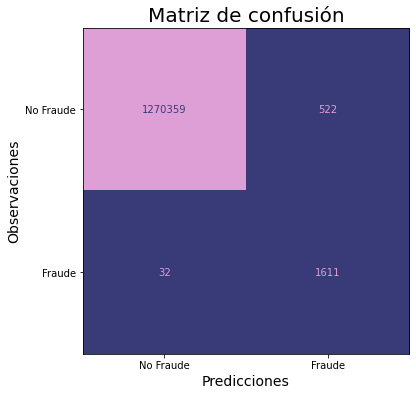

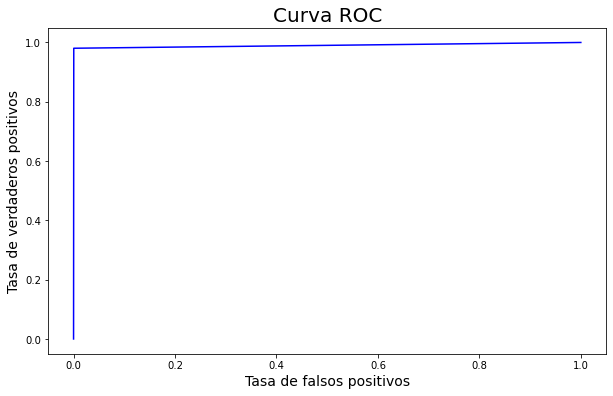

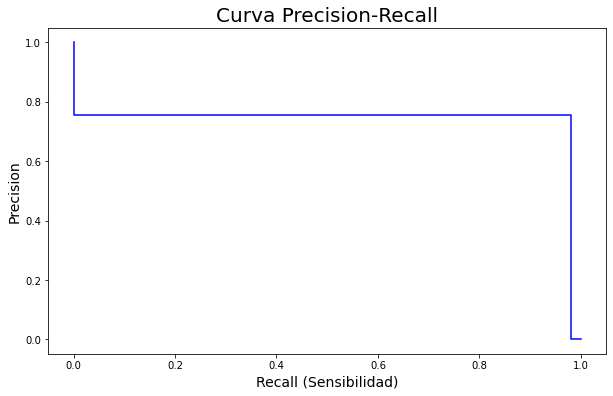

In [9]:
# Exportación a png.
from export import export_png
export_png(filename = 'neural_network_balanced', y_test = y_test, y_pred = y_pred)

#### 10.3.5. Ensambles: Random Forest

##### 10.3.5.1. Primera optimización de hiperparámetros

In [15]:
# Importación de librerías
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from math import log

# Ingeniería de predictores seleccionada.
sss = StratifiedShuffleSplit(n_splits = 1, train_size = 0.5, random_state = 42)
selected_columns = ['isFraud', 'isFlaggedFraud']

for a, b in sss.split(df_training, y = df_training['isFraud']):
    X = df_training.iloc[a,:-2]
    y = df_training.iloc[a,-2]
    
# Definición del espacio / dominio de parámetros.
estimator = RandomForestClassifier()
search_space = {'params' : {'n_estimators' : hp.randint('n_estimators', 1, 100),
                            'max_depth' : hp.qlognormal('max_depth', log(10), log(2), 1),
                            'min_samples_leaf' : hp.randint('min_samples_leaf', 1, 5),
                            'min_samples_split' : hp.randint('min_samples_split', 2, 5),              
                            'class_weight' : hp.choice('class_weight', ['balanced', None]),
                            'criterion' : hp.choice('criterion', ['entropy', 'gini']),
                            'max_features' : hp.uniform('max_features', 0.1, 1),
                            'max_samples' : hp.uniform('max_samples', 0.1, 1),
                            'random_state' : 42
                           }
               }

# Implementación de Hyperopt
counter = -1
scorings = list()
rstate = np.random.default_rng(42)
trials = Trials() # Para el logging de resultados.
best_params = fmin(fn = objective_func, 
                   space = search_space, 
                   algo = tpe.suggest, 
                   max_evals = 100, 
                   trials = trials, 
                   early_stop_fn = no_progress_loss(50), 
                   rstate = rstate)

# Impresión de resultados.
hyperopt_printer(trials)
json_export(scorings)
scorings_df = scorings_to_df(scorings)

Trial: 0 | Loss: 0.1311 | Elapsed_time: 18.6171 seconds
Trial: 1 | Loss: 0.1200 | Elapsed_time: 128.3365 seconds                         
Trial: 2 | Loss: 0.3245 | Elapsed_time: 16.8543 seconds                           
Trial: 3 | Loss: 0.0891 | Elapsed_time: 220.9827 seconds                          
Trial: 4 | Loss: 0.1081 | Elapsed_time: 47.5080 seconds                              
Trial: 5 | Loss: 0.0961 | Elapsed_time: 214.1034 seconds                             
Trial: 6 | Loss: 0.1333 | Elapsed_time: 131.1139 seconds                             
Trial: 7 | Loss: 0.1429 | Elapsed_time: 107.7779 seconds                             
Trial: 8 | Loss: 0.1852 | Elapsed_time: 8.7844 seconds                               
Trial: 9 | Loss: 0.0943 | Elapsed_time: 254.2926 seconds                             
Trial: 10 | Loss: 0.0921 | Elapsed_time: 22.5398 seconds                              
Trial: 11 | Loss: 0.2868 | Elapsed_time: 59.0073 seconds                              
Trial:

##### 10.3.5.2. Segunda optimización de hiperparámetros

Best Trial:
Trial ID : 29
Loss : 0.07846154171411873
Params : {'params': {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 26.0, 'max_features': 0.8762318649368235, 'max_samples': 0.8370855027715005, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 23, 'random_state': 42}}

In [122]:
# Función objetivo.
def objective_func_rf(search_space, alpha):
    
    global counter, scorings, estimator
    start_time = time.time()
    counter +=1
    
    search_space['params']['ccp_alpha'] = alpha
    
    estimator.set_params(**search_space['params'])
    
    skf = StratifiedKFold(random_state = 42, n_splits = 4, shuffle = True)    
    
    scores = {'Recall': [],
              'Precision': [],
              'AUC': [],
              'Accuracy': [],
              'F1-Score': []
             }
    
    for train, test in skf.split(X = X, y = y):
        
        X_train = X.iloc[train, :]
        X_test = X.iloc[test, :]
        y_train = y.iloc[train]
        y_test = y.iloc[test]

        indexes_train = balancing(X_train, y_train, 0.8)
        indexes_test = balancing(X_test, y_test, 0.8)

        X_train = X_train.loc[indexes_train, :]
        X_test = X_test.loc[indexes_test, :]
        y_train = y_train.loc[indexes_train]
        y_test = y_test.loc[indexes_test]
        
        estimator.fit(X_train, y_train)
        y_pred = estimator.predict(X_test)
        
        scores['Recall'].append(recall_score(y_test, y_pred))
        scores['Precision'].append(precision_score(y_test, y_pred))
        scores['AUC'].append(roc_auc_score(y_test, y_pred))
        scores['Accuracy'].append(accuracy_score(y_test, y_pred))
        scores['F1-Score'].append(f1_score(y_test, y_pred))
    
    loss = 1 - np.mean(scores['F1-Score']) + np.std(scores['F1-Score'])

    scorings.append({'trial': counter,
                     'search_space' : str(search_space),
                     'scorings' : {'Recall': np.mean(scores['Recall']),
                                   'Precision': np.mean(scores['Precision']),
                                   'AUC': np.mean(scores['AUC']),
                                   'Accuracy': np.mean(scores['Accuracy']),
                                   'Recall_Std': np.std(scores['Recall']),
                                   'Precision_Std': np.std(scores['Precision']),
                                   'AUC_Std': np.std(scores['AUC']),
                                   'Accuracy_Std': np.std(scores['Accuracy']),
                                   'F1-Score': np.mean(scores['F1-Score'])}
                    }
                   )
    
    elapsed_time = time.time() - start_time
    
    print('Trial: %i | Loss: %.4f | Elapsed_time: %.4f seconds' % (counter, loss, elapsed_time))
    
    return scorings

In [123]:
# Importación de librerías
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from math import log
from joblib import Parallel, delayed

# Ingeniería de predictores seleccionada.
sss = StratifiedShuffleSplit(n_splits = 1, train_size = 0.2, random_state = 42)

for a, b in sss.split(df_training, y = df_training['isFraud']):
    X = df_training.iloc[a,:-2]
    y = df_training.iloc[a,-2]
    
# Definición del espacio / dominio de parámetros.
estimator = RandomForestClassifier()
search_space = {'params' : {'class_weight': 'balanced', 
                            'criterion': 'entropy', 
                            'max_depth': 26, 
                            'max_features': 0.8762318649368235, 
                            'max_samples': 0.8370855027715005, 
                            'min_samples_leaf': 3, 
                            'min_samples_split': 3, 
                            'n_estimators': 23, 
                            'random_state': 42
                           }
               }
alphas = [i / 1000 for i in range(1, 101, 1)]

# Iteración.
counter = -1
scorings = list()
results = Parallel(n_jobs = -1, verbose = 100, )(delayed(objective_func_rf)(search_space, alpha) for alpha in alphas)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  2

In [133]:
scorings_df = scorings_to_df([result[0] for result in results])

Scoring details:

      Recall  Precision       AUC  Accuracy  Recall_Std  Precision_Std   AUC_Std  Accuracy_Std  F1-Score
0   0.964461   0.628410  0.978864  0.992936    0.007313       0.046840  0.003661      0.001350  0.759965
1   0.981382   0.507655  0.985082  0.988697    0.009285       0.040303  0.004385      0.001803  0.668113
2   0.985188   0.450099  0.985559  0.985922    0.007335       0.023440  0.003439      0.001378  0.617492
3   0.986883   0.410864  0.985162  0.983481    0.007713       0.025266  0.003910      0.001711  0.579729
4   0.985612   0.352186  0.982154  0.978775    0.009779       0.028238  0.004628      0.002782  0.518242
5   0.985188   0.329537  0.980757  0.976427    0.009396       0.032450  0.004565      0.003729  0.492927
6   0.985188   0.295033  0.978809  0.972577    0.009396       0.020305  0.003365      0.002684  0.453595
7   0.985612   0.282563  0.978141  0.970842    0.008690       0.021003  0.003169      0.002967  0.438704
8   0.985612   0.255474  0.975974  0.

In [137]:
scorings_df.sort_values('F1-Score', ascending = False)

,Recall,Precision,AUC,Accuracy,Recall_Std,Precision_Std,AUC_Std,Accuracy_Std,F1-Score
0,0.964461,0.628410,0.978864,0.992936,0.007313,0.046840,0.003661,0.001350,0.759965
1,0.981382,0.507655,0.985082,0.988697,0.009285,0.040303,0.004385,0.001803,0.668113
2,0.985188,0.450099,0.985559,0.985922,0.007335,0.023440,0.003439,0.001378,0.617492
3,0.986883,0.410864,0.985162,0.983481,0.007713,0.025266,0.003910,0.001711,0.579729
4,0.985612,0.352186,0.982154,0.978775,0.009779,0.028238,0.004628,0.002782,0.518242
...,...,...,...,...,...,...,...,...,...
40,0.974598,0.170741,0.958682,0.943132,0.015598,0.028842,0.006162,0.012749,0.289372
37,0.974598,0.170733,0.958679,0.943127,0.015598,0.028852,0.006163,0.012756,0.289361
42,0.973331,0.170616,0.958061,0.943142,0.014619,0.028765,0.005126,0.012751,0.289134
43,0.968263,0.169833,0.955527,0.943083,0.013844,0.028377,0.001676,0.012719,0.287769


A medida que el valor de alpha es menor, mayor es la perfomance del modelo.

##### 10.3.5.3. Evaluación del modelo sobre el conjunto de validación

Best Trial:
Trial ID : 29
Loss : 0.07846154171411873
Params : {'params': {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 26.0, 'max_features': 0.8762318649368235, 'max_samples': 0.8370855027715005, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 23, 'random_state': 42}}

In [7]:
# Evaluación con el conjunto de validación.
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

# Configuración del estimador.
params = {'class_weight': 'balanced',
          'criterion': 'entropy', 
          'max_depth': 26, 
          'max_features': 0.8762318649368235, 
          'max_samples': 0.8370855027715005, 
          'min_samples_leaf': 3, 
          'min_samples_split': 3, 
          'n_estimators': 23, 
          'random_state': 42}

# Ingeniería de predictores seleccionada.
selected_columns = ['isFraud', 'isFlaggedFraud']
X_train = df_training.drop(selected_columns, axis = 1)
y_train = df_training['isFraud']
X_test = df_validation.drop(selected_columns, axis = 1)
y_test = df_validation['isFraud']

# Balanceo de datos.
indexes = balancing(X_train, y_train, 0.8)
X_balanced = X_train.loc[indexes, :]
y_balanced = y_train.loc[indexes]

# Entrenamiento del modelo.
clf = RandomForestClassifier(**params)
clf.fit(X = X_balanced, y = y_balanced)

# Aplicación del modelo entrenado sobre el conjunto de validación.
y_pred = clf.predict(X_test)

# Obtención de métricas.
print('Recall: %.4f' % recall_score(y_true = y_test, y_pred = y_pred))
print('Precision: %.4f' % precision_score(y_true = y_test, y_pred = y_pred))
print('AUC: %.4f' % roc_auc_score(y_true = y_test, y_score = y_pred))
print('Accuracy: %.4f' % accuracy_score(y_true = y_test, y_pred = y_pred))
print('F1-Score: %.4f' % f1_score(y_true = y_test, y_pred = y_pred))

Recall: 0.9507
Precision: 0.7385
AUC: 0.9751
Accuracy: 0.9995
F1-Score: 0.8313


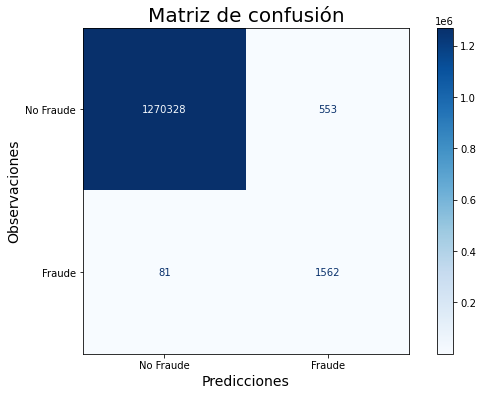

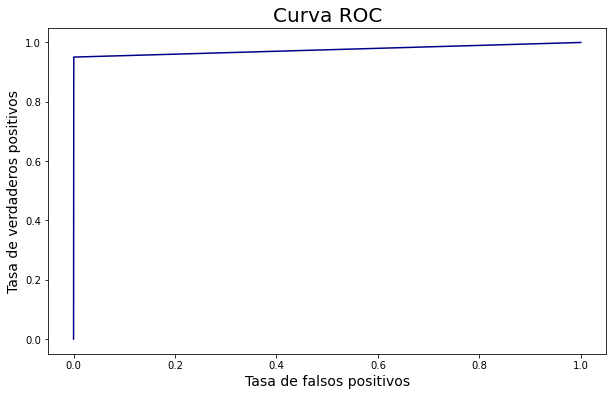

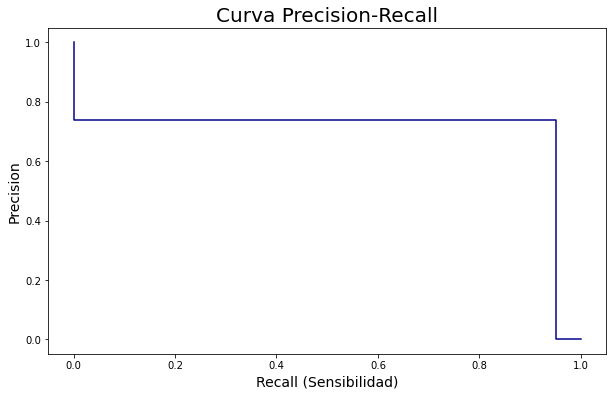

In [8]:
# Exportación a png.
from export import export_png_2
export_png_2(filename = 'random_forest_balanced', y_test = y_test, y_pred = y_pred)

#### 10.3.6. Ensambles: Bagging SVM

##### 10.3.6.1. Optimización de hiperparámetros

In [13]:
# Importación de librerías
from sklearn.svm import LinearSVC
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import RobustScaler
from math import log

# Ingeniería de predictores seleccionada.
sss = StratifiedShuffleSplit(n_splits = 1, train_size = 0.2, random_state = 42)
selected_columns = ['day', 'idOrig', 'idDest', 'oldbalanceDest', 'newbalanceDest']
scaler = RobustScaler()

for a, b in sss.split(df_training, y = df_training['isFraud']):
    X = df_training.iloc[a,:-2]
    y = df_training.iloc[a,-2]

indexes = X.index
X = X.drop(selected_columns, axis = 1)
X = scaler.fit_transform(X)
X = pd.DataFrame(X)
X.index = indexes

# Definición del espacio / dominio de parámetros.
clf_params = {'C': 1.0026895733272085, 
              'class_weight': None, 
              'fit_intercept': True, 
              'intercept_scaling': 1.013090208053348, 
              'loss': 'hinge', 
              'max_iter': 28, 
              'penalty': 'l2', 
              'random_state': 42, 
              'tol': 9.570017427461634e-05
             }
clf = LinearSVC(**clf_params)
estimator = BaggingClassifier(base_estimator = clf, n_jobs = -1, random_state = 42)
search_space = {'params' : {'n_estimators' : hp.choice('n_estimators', [1, 5, 10, 15, 20]), 
                            'max_samples' : hp.uniform('max_samples', 0.8, 1.0),
                            'max_features' : hp.uniform('max_features', 0.8, 1.0)
                           }
               }

# Implementación de Hyperopt
counter = -1
scorings = list()
rstate = np.random.default_rng(42)
trials = Trials() # Para el logging de resultados.
best_params = fmin(fn = objective_func, 
                   space = search_space, 
                   algo = tpe.suggest, 
                   max_evals = 100, 
                   trials = trials, 
                   early_stop_fn = no_progress_loss(50), 
                   rstate = rstate)

# Impresión de resultados.
hyperopt_printer(trials)
json_export(scorings)
scorings_df = scorings_to_df(scorings)

Trial: 0 | Loss: 1.0053 | Elapsed_time: 2.9417 seconds 
Trial: 1 | Loss: 0.3516 | Elapsed_time: 10.6814 seconds                          
Trial: 2 | Loss: 1.0012 | Elapsed_time: 2.5502 seconds                           
Trial: 3 | Loss: 0.3637 | Elapsed_time: 8.7230 seconds                           
Trial: 4 | Loss: 0.5540 | Elapsed_time: 5.5610 seconds                           
Trial: 5 | Loss: 0.4735 | Elapsed_time: 9.6589 seconds                           
Trial: 6 | Loss: 0.6287 | Elapsed_time: 9.2830 seconds                           
Trial: 7 | Loss: 0.3824 | Elapsed_time: 7.3332 seconds                           
Trial: 8 | Loss: 1.0000 | Elapsed_time: 2.5532 seconds                           
Trial: 9 | Loss: 0.4109 | Elapsed_time: 10.7899 seconds                          
Trial: 10 | Loss: 1.0000 | Elapsed_time: 2.4893 seconds                           
Trial: 11 | Loss: 0.4369 | Elapsed_time: 10.8347 seconds                          
Trial: 12 | Loss: 0.3442 | Elapsed_time:

##### 10.3.6.2. Evaluación del modelo sobre el conjunto de validación

Best Trial:
Trial ID : 36
Loss : 0.318408832968835
Params : {'params': {'max_features': 0.9531431016263201, 'max_samples': 0.8283494923707083, 'n_estimators': 20}}

In [9]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score

# Definición del espacio / dominio de parámetros.
estimator_params = {'C': 1.0026895733272085, 'class_weight': None, 'fit_intercept': True, 'intercept_scaling': 1.013090208053348, 
                      'loss': 'hinge', 'max_iter': 28, 'penalty': 'l2', 'random_state': 42, 'tol': 9.570017427461634e-05}
params = {'max_features': 0.9531431016263201, 'max_samples': 0.8283494923707083, 'n_estimators': 20, 'n_jobs' : -1, 'random_state' : 42}
selected_columns = ['isFraud', 'isFlaggedFraud', 'day', 'hour', 'idOrig', 'idDest']
scaler = RobustScaler()

# Ingeniería de predictores seleccionada.
X_train = df_training.drop(selected_columns, axis = 1)
train_index = X_train.index
train_columns = X_train.columns
X_train = pd.DataFrame(scaler.fit_transform(X_train), index = train_index, columns = train_columns)
y_train = df_training['isFraud']

X_test = df_validation.drop(selected_columns, axis = 1)
test_index = X_test.index
test_columns = X_test.columns
X_test = pd.DataFrame(scaler.fit_transform(X_test), index = test_index, columns = test_columns)
y_test = df_validation['isFraud']

# Balanceo de datos.
indexes = balancing(X_train, y_train, 0.8)
X_balanced = X_train.loc[indexes, :]
y_balanced = y_train.loc[indexes]

# Entrenamiento del modelo.
estimator = LinearSVC(**estimator_params)
clf = BaggingClassifier(**params, base_estimator = estimator)
clf.fit(X = X_balanced, y = y_balanced)

# Predicción de resultados.
y_pred = clf.predict(X_test)

# Obtención de métricas.
print('Recall: %.4f' % recall_score(y_true = y_test, y_pred = y_pred))
print('Precision: %.4f' % precision_score(y_true = y_test, y_pred = y_pred))
print('AUC: %.4f' % roc_auc_score(y_true = y_test, y_score = y_pred))
print('Accuracy: %.4f' % accuracy_score(y_true = y_test, y_pred = y_pred))
print('F1-Score: %.4f' % f1_score(y_true = y_test, y_pred = y_pred))

Recall: 0.5666
Precision: 0.7950
AUC: 0.7832
Accuracy: 0.9993
F1-Score: 0.6617


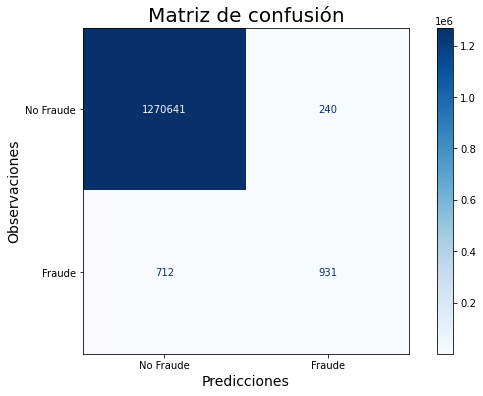

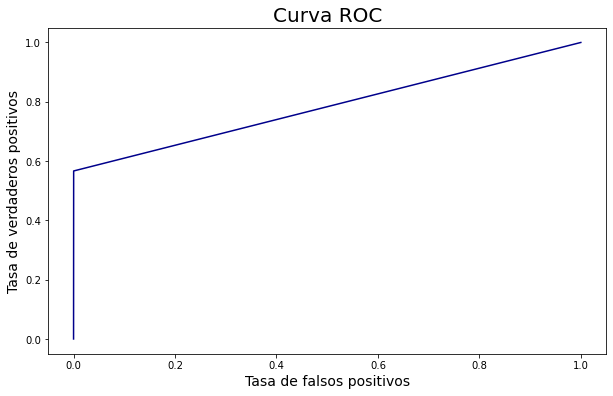

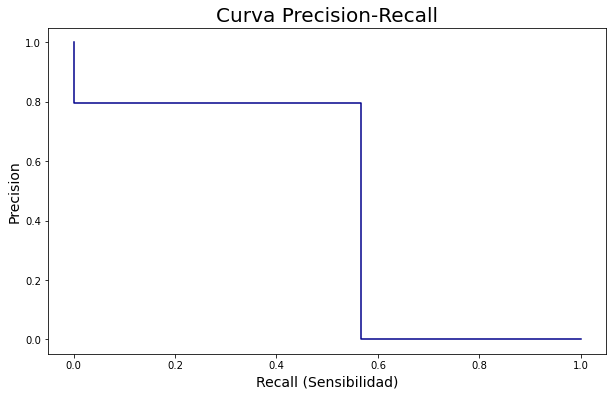

In [10]:
# Exportación a png.
from export import export_png_2
export_png_2(filename = 'bagging_svm_balanced', y_test = y_test, y_pred = y_pred)

#### 10.3.7. Ensambles: Bagging Redes Neuronales

##### 10.3.7.1. Optimización de hiperparámetros

Se toma el modelo optimizado y se aplica un ensamble de tipo bagging.

Best Trial:
Trial ID : 10
Loss : 0.022286462923831532
Params : {'params': {'activation': 'logistic', 'alpha': 9.882145575443431e-05, 'hidden_layer_sizes': (1, 5, 1), 'random_state': 42, 'solver': 'lbfgs'}}

Debido a inconsistencias en los resultados, se modificó el parámetro "activation" de "logistic" por "tanh".

In [31]:
# Importación de librerías
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import RobustScaler

# Ingeniería de predictores seleccionada.
sss = StratifiedShuffleSplit(n_splits = 1, train_size = 0.1, random_state = 42)
selected_columns = ['idOrig', 'idDest', 'oldbalanceDest', 'newbalanceDest']
scaler = RobustScaler()

for a, b in sss.split(df_training, y = df_training['isFraud']):
    X = df_training.iloc[a,:-2]
    y = df_training.iloc[a,-2]

indexes = X.index
X = X.drop(selected_columns, axis = 1)
X = scaler.fit_transform(X)
X = pd.DataFrame(X)
X.index = indexes

# Definición del espacio / dominio de parámetros.
clf_params = {'activation': 'tanh', 'alpha': 9.882145575443431e-05, 'hidden_layer_sizes': (1, 5, 1), 'random_state': 42, 'solver': 'lbfgs'}
clf = MLPClassifier(**clf_params)
estimator = BaggingClassifier(base_estimator = clf, n_jobs = -1, random_state = 42)
search_space = {'params' : {'n_estimators' : hp.choice('n_estimators', [1, 5, 10, 15, 20]), 
                            'max_samples' : hp.uniform('max_samples', 0.8, 1.0),
                            'max_features' : hp.uniform('max_features', 0.8, 1.0)
                           }
               }

# Implementación de Hyperopt
counter = -1
scorings = list()
rstate = np.random.default_rng(42)
trials = Trials() # Para el logging de resultados.
best_params = fmin(fn = objective_func, 
                   space = search_space, 
                   algo = tpe.suggest, 
                   max_evals = 100, 
                   trials = trials, 
                   early_stop_fn = no_progress_loss(50), 
                   rstate = rstate)

# Impresión de resultados.
hyperopt_printer(trials)
json_export(scorings)
scorings_df = scorings_to_df(scorings)

Trial: 0 | Loss: 0.0252 | Elapsed_time: 22.8347 seconds
Trial: 1 | Loss: 0.1038 | Elapsed_time: 88.0824 seconds                            
Trial: 2 | Loss: 0.0223 | Elapsed_time: 18.1411 seconds                              
Trial: 3 | Loss: 0.1929 | Elapsed_time: 53.6360 seconds                              
Trial: 4 | Loss: 0.2595 | Elapsed_time: 23.2346 seconds                             
Trial: 5 | Loss: 0.5954 | Elapsed_time: 52.2811 seconds                             
Trial: 6 | Loss: 0.7198 | Elapsed_time: 71.3826 seconds                             
Trial: 7 | Loss: 0.0887 | Elapsed_time: 57.8076 seconds                             
Trial: 8 | Loss: 0.4342 | Elapsed_time: 10.9546 seconds                             
Trial: 9 | Loss: 0.7364 | Elapsed_time: 77.9585 seconds                             
Trial: 10 | Loss: 0.4357 | Elapsed_time: 9.3071 seconds                              
Trial: 11 | Loss: 0.6545 | Elapsed_time: 78.3525 seconds                             
Trial:

##### 10.3.7.2. Evaluación del modelo sobre el conjunto de validación

Best Trial:
Trial ID : 12
Loss : 0.022286462923831532
Params : {'params': {'max_features': 0.9218208298176639, 'max_samples': 0.9460079200724107, 'n_estimators': 5}}

In [32]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score

# Definición del espacio / dominio de parámetros.
estimator_params = {'activation': 'tanh', 'alpha': 9.882145575443431e-05, 'hidden_layer_sizes': (1, 5, 1), 'random_state': 42, 'solver': 'lbfgs'}
params = {'max_features': 0.9218208298176639, 'max_samples': 0.9460079200724107, 'n_estimators': 5, 'n_jobs' : -1, 'random_state' : 42}
selected_columns = ['isFraud', 'isFlaggedFraud', 'idOrig', 'idDest', 'oldbalanceDest', 'newbalanceDest']
scaler = RobustScaler()

# Ingeniería de predictores seleccionada.
X_train = df_training.drop(selected_columns, axis = 1)
train_index = X_train.index
train_columns = X_train.columns
X_train = pd.DataFrame(scaler.fit_transform(X_train), index = train_index, columns = train_columns)
y_train = df_training['isFraud']

X_test = df_validation.drop(selected_columns, axis = 1)
test_index = X_test.index
test_columns = X_test.columns
X_test = pd.DataFrame(scaler.fit_transform(X_test), index = test_index, columns = test_columns)
y_test = df_validation['isFraud']

# Balanceo de datos.
indexes = balancing(X_train, y_train, 0.8)
X_balanced = X_train.loc[indexes, :]
y_balanced = y_train.loc[indexes]

# Entrenamiento del modelo.
estimator = MLPClassifier(**estimator_params)
clf = BaggingClassifier(**params, base_estimator = estimator)
clf.fit(X = X_balanced, y = y_balanced)

# Predicción de resultados.
y_pred = clf.predict(X_test)

# Obtención de métricas.
print('Recall: %.4f' % recall_score(y_true = y_test, y_pred = y_pred))
print('Precision: %.4f' % precision_score(y_true = y_test, y_pred = y_pred))
print('AUC: %.4f' % roc_auc_score(y_true = y_test, y_score = y_pred))
print('Accuracy: %.4f' % accuracy_score(y_true = y_test, y_pred = y_pred))
print('F1-Score: %.4f' % f1_score(y_true = y_test, y_pred = y_pred))

Recall: 0.9805
Precision: 0.8369
AUC: 0.9901
Accuracy: 0.9997
F1-Score: 0.9030


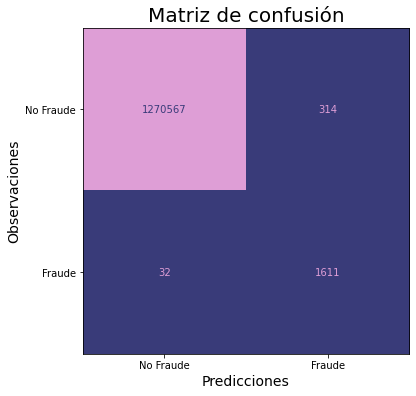

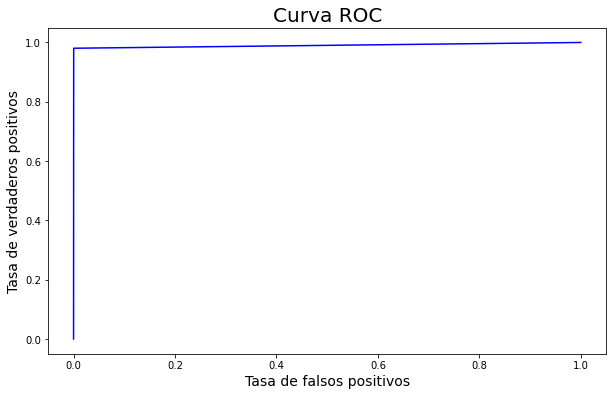

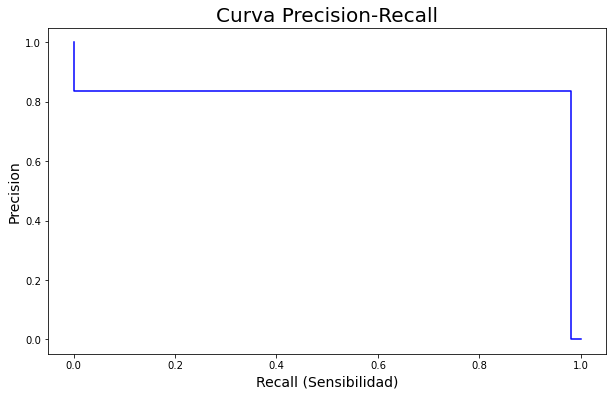

In [33]:
# Exportación a png.
from export import export_png
export_png(filename = 'bagging_nn_balanced', y_test = y_test, y_pred = y_pred)

#### 10.3.8. Gradient Boosted Trees

##### 10.3.8.1. Optimizacion de hiperparametros

In [11]:
# Importación de librerías
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedShuffleSplit

# Ingeniería de predictores seleccionada.
sss = StratifiedShuffleSplit(n_splits = 1, train_size = 0.2, random_state = 42)

for a, b in sss.split(df_training, y = df_training['isFraud']):
    X = df_training.iloc[a,:-2]
    y = df_training.iloc[a,-2]

# Definición del espacio / dominio de parámetros.
estimator = GradientBoostingClassifier()
search_space = {'params' : {'n_estimators' : hp.choice('n_estimators', [1, 3, 5, 10, 15, 20]),
                            'max_features' : hp.uniform('max_features', 0.8, 1.0),
                            'max_depth' : hp.randint('max_depth', 3, 10),
                            'learning_rate' : hp.uniform('learning_rate', 0.01, 0.20),
                            'subsample' : hp.uniform('subsample', 0.8, 1.0),
                            'min_samples_split' : hp.randint('min_samples_split', 2, 5),
                            'min_samples_leaf' : hp.randint('min_samples_leaf', 1, 5),
                            'random_state' : 42
                           }
               }

# Implementación de Hyperopt
counter = -1
scorings = list()
rstate = np.random.default_rng(42)
trials = Trials() # Para el logging de resultados.
best_params = fmin(fn = objective_func, 
                   space = search_space, 
                   algo = tpe.suggest, 
                   max_evals = 100, 
                   trials = trials, 
                   early_stop_fn = no_progress_loss(50), 
                   rstate = rstate)

# Impresión de resultados.
hyperopt_printer(trials)
json_export(scorings)
scorings_df = scorings_to_df(scorings)

Trial: 0 | Loss: 0.1401 | Elapsed_time: 33.2454 seconds
Trial: 1 | Loss: 0.1634 | Elapsed_time: 14.8256 seconds                           
Trial: 2 | Loss: 0.1945 | Elapsed_time: 7.5967 seconds                            
Trial: 3 | Loss: 1.0000 | Elapsed_time: 4.2805 seconds                            
Trial: 4 | Loss: 0.3233 | Elapsed_time: 17.6380 seconds                           
Trial: 5 | Loss: 0.1932 | Elapsed_time: 12.5027 seconds                           
Trial: 6 | Loss: 0.7243 | Elapsed_time: 3.1087 seconds                            
Trial: 7 | Loss: 0.2180 | Elapsed_time: 35.6849 seconds                           
Trial: 8 | Loss: 0.2927 | Elapsed_time: 7.0542 seconds                            
Trial: 9 | Loss: 0.1574 | Elapsed_time: 11.6661 seconds                           
Trial: 10 | Loss: 0.2016 | Elapsed_time: 14.4873 seconds                           
Trial: 11 | Loss: 0.7275 | Elapsed_time: 5.0555 seconds                            
Trial: 12 | Loss: 0.1545 | El

##### 10.3.8.2. Evaluación del modelo sobre el conjunto de validación

Best Trial:
Trial ID : 66
Loss : 0.11021594298912685
Params : {'params': {'learning_rate': 0.08559612517281782, 'max_depth': 8, 'max_features': 0.9275470891227539, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 20, 'random_state': 42, 'subsample': 0.9502113659155212}}

In [11]:
# Importación de librerías
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score

# Definición del espacio / dominio de parámetros.
selected_columns = ['isFraud', 'isFlaggedFraud']
params =  {'learning_rate': 0.08559612517281782, 
           'max_depth': 8, 
           'max_features': 0.9275470891227539, 
           'min_samples_leaf': 2, 
           'min_samples_split': 3, 
           'n_estimators': 20, 
           'random_state': 42, 
           'subsample': 0.9502113659155212}

# Ingeniería de predictores seleccionada.
X_train = df_training.drop(selected_columns, axis = 1)
y_train = df_training['isFraud']
X_test = df_validation.drop(selected_columns, axis = 1)
y_test = df_validation['isFraud']

# Balanceo de datos.
indexes = balancing(X_train, y_train, 0.8)
X_balanced = X_train.loc[indexes, :]
y_balanced = y_train.loc[indexes]

# Entrenamiento del modelo.
clf = GradientBoostingClassifier(**params)
clf.fit(X = X_balanced, y = y_balanced)

# Predicción de resultados.
y_pred = clf.predict(X_test)

# Obtención de métricas.
print('Recall: %.4f' % recall_score(y_true = y_test, y_pred = y_pred))
print('Precision: %.4f' % precision_score(y_true = y_test, y_pred = y_pred))
print('AUC: %.4f' % roc_auc_score(y_true = y_test, y_score = y_pred))
print('Accuracy: %.4f' % accuracy_score(y_true = y_test, y_pred = y_pred))
print('F1-Score: %.4f' % f1_score(y_true = y_test, y_pred = y_pred))

Recall: 0.8691
Precision: 0.7596
AUC: 0.9344
Accuracy: 0.9995
F1-Score: 0.8107


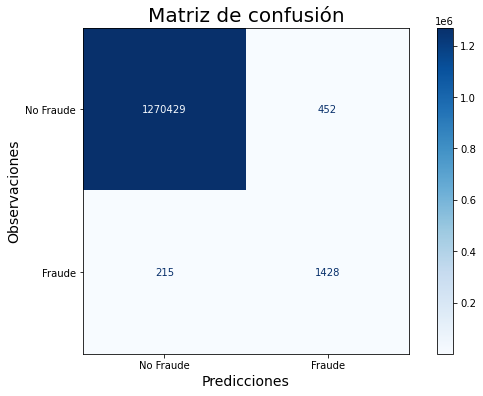

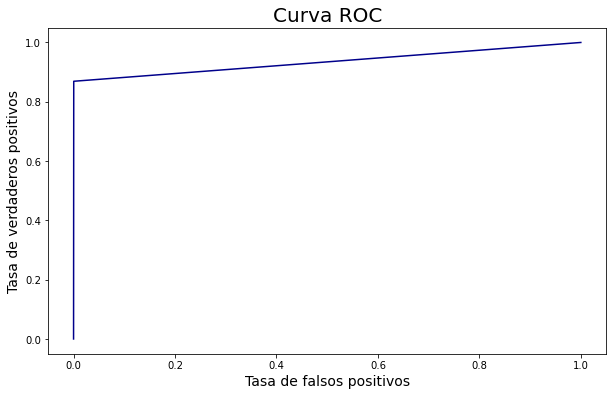

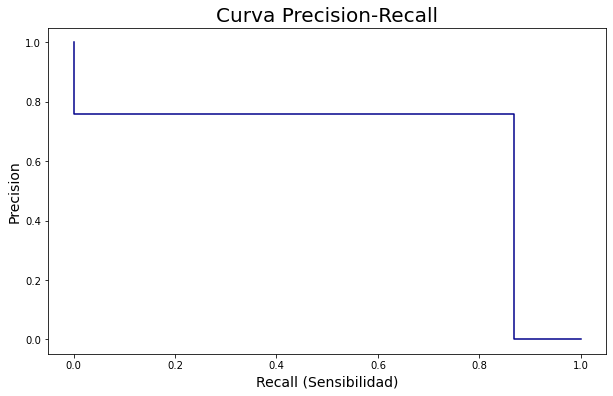

In [12]:
# Exportación a png.
from export import export_png_2
export_png_2(filename = 'gbt_balanced', y_test = y_test, y_pred = y_pred)

#### 10.3.9. XGBoost

- https://www.kaggle.com/prashant111/xgboost-k-fold-cv-feature-importance
- https://xgboost.readthedocs.io/en/stable/index.html
- https://www.datacamp.com/community/tutorials/xgboost-in-python?utm_source=adwords_ppc&utm_medium=cpc&utm_campaignid=1455363063&utm_adgroupid=65083631748&utm_device=c&utm_keyword=&utm_matchtype=&utm_network=g&utm_adpostion=&utm_creative=278443377095&utm_targetid=aud-392016246653:dsa-429603003980&utm_loc_interest_ms=&utm_loc_physical_ms=1000073

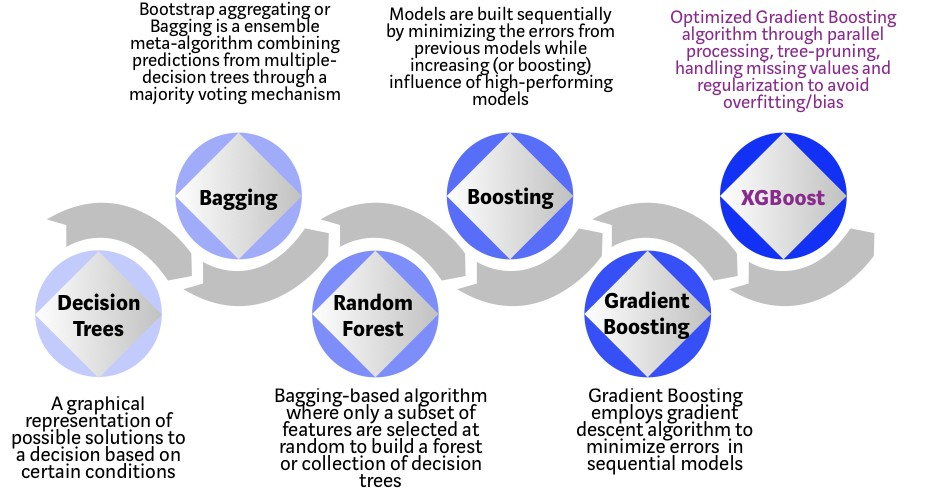

##### 10.3.9.1. Primera optimización de hiperparámetros

In [24]:
# Importación de librerías
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate, StratifiedShuffleSplit
from hyperopt import fmin, hp, tpe, space_eval, Trials
from hyperopt.early_stop import no_progress_loss

# Ingeniería de predictores.
sss = StratifiedShuffleSplit(n_splits = 1, train_size = 0.2, random_state = 42)

for a, b in sss.split(df_training, y = df_training['isFraud']):
    X = df_training.iloc[a,:-2]
    y = df_training.iloc[a,-2]

# Definición del espacio / dominio de parámetros.
estimator = XGBClassifier()
search_space = {'params' : {'n_estimators' : hp.randint('a', 1, 1000),
                            'max_depth' : hp.randint('b', 3, 20),
                            'learning_rate' : hp.choice('c', [0.01, 0.05, 0.1, 0.15, 0.2]),
                            'gamma' : hp.uniform('d', 0, 1),
                            'min_child_weight' : hp.uniform('e', 0, 1),
                            'max_delta_step' : hp.uniform('f', 0, 1),
                            'subsample' : hp.uniform('g', 0, 1),
                            'colsample_bytree' : hp.uniform('h', 0, 1),
                            'colsample_bylevel' : hp.uniform('i', 0, 1),
                            'colsample_bynode' : hp.uniform('j', 0, 1),
                            'reg_alpha' : hp.uniform('k', 0, 1),
                            'reg_lambda' : hp.uniform('l', 0, 1),
                            'scale_pos_weight' : hp.uniform('m', 0, 1),
                            'random_state' : 42,
                            'tree_method' : 'gpu_hist',
                            'gpu_id' : 0
                           }
               }

# Ejecución del optimizador.
counter = -1
scorings = list()
rstate = np.random.default_rng(42)
trials = Trials() # Para el logging de resultados.
best_params = fmin(fn = objective_func, 
                   space = search_space, 
                   algo = tpe.suggest, 
                   max_evals = 200, 
                   trials = trials, 
                   early_stop_fn = no_progress_loss(100), 
                   rstate = rstate)

# Impresión de resultados.
hyperopt_printer(trials)
json_export(scorings)
scorings_df = scorings_to_df(scorings)

Trial: 0 | Loss: 0.5444 | Elapsed_time: 8.0864 seconds 
Trial: 1 | Loss: 1.0000 | Elapsed_time: 3.8627 seconds                          
Trial: 2 | Loss: 0.1609 | Elapsed_time: 7.7109 seconds                          
Trial: 3 | Loss: 0.8494 | Elapsed_time: 4.0354 seconds                            
Trial: 4 | Loss: 0.1285 | Elapsed_time: 12.6965 seconds                           
Trial: 5 | Loss: 0.1354 | Elapsed_time: 5.4933 seconds                            
Trial: 6 | Loss: 1.0000 | Elapsed_time: 5.3882 seconds                           
Trial: 7 | Loss: 0.4948 | Elapsed_time: 5.6459 seconds                           
Trial: 8 | Loss: 0.9921 | Elapsed_time: 3.2094 seconds                           
Trial: 9 | Loss: 1.0000 | Elapsed_time: 2.7766 seconds                           
Trial: 10 | Loss: 0.9719 | Elapsed_time: 3.1416 seconds                           
Trial: 11 | Loss: 0.1250 | Elapsed_time: 6.2303 seconds                           
Trial: 12 | Loss: 1.0000 | Elapsed_time

##### 10.3.9.2. Evaluación en el conjunto de validación

Best Trial:
Trial ID : 183
Loss : 0.10069527129346727
Params : {'params': {'colsample_bylevel': 0.5159289901788265, 'colsample_bynode': 0.683421710672661, 'colsample_bytree': 0.9229862438842107, 'gamma': 0.1542273620039968, 'gpu_id': 0, 'learning_rate': 0.15, 'max_delta_step': 0.9988063160725104, 'max_depth': 4, 'min_child_weight': 0.498151114117041, 'n_estimators': 304, 'random_state': 42, 'reg_alpha': 0.7617504152023389, 'reg_lambda': 0.051201180233103605, 'scale_pos_weight': 0.9423971486162506, 'subsample': 0.6492775907229061, 'tree_method': 'gpu_hist'}}

In [26]:
# Importación de librerías
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score

# Definición del espacio / dominio de parámetros.
params =  {'colsample_bylevel': 0.5159289901788265, 'colsample_bynode': 0.683421710672661, 'colsample_bytree': 0.9229862438842107, 'gamma': 0.1542273620039968, 
           'gpu_id': 0, 'learning_rate': 0.15, 'max_delta_step': 0.9988063160725104, 'max_depth': 4, 'min_child_weight': 0.498151114117041, 'n_estimators': 304, 
           'random_state': 42, 'reg_alpha': 0.7617504152023389, 'reg_lambda': 0.051201180233103605, 'scale_pos_weight': 0.9423971486162506, 'subsample': 0.6492775907229061, 
           'tree_method': 'gpu_hist'}

# Ingeniería de predictores seleccionada.
selected_columns = ['isFraud', 'isFlaggedFraud']
X_train = df_training.drop(selected_columns, axis = 1)
y_train = df_training['isFraud']
X_test = df_validation.drop(selected_columns, axis = 1)
y_test = df_validation['isFraud']

# Balanceo de datos.
indexes = balancing(X_train, y_train, 0.8)
X_balanced = X_train.loc[indexes, :]
y_balanced = y_train.loc[indexes]

# Entrenamiento del modelo.
clf = XGBClassifier(**params)
clf.fit(X = X_balanced, y = y_balanced)

# Predicción de resultados.
y_pred = clf.predict(X_test)

# Obtención de métricas.
print('Recall: %.4f' % recall_score(y_true = y_test, y_pred = y_pred))
print('Precision: %.4f' % precision_score(y_true = y_test, y_pred = y_pred))
print('AUC: %.4f' % roc_auc_score(y_true = y_test, y_score = y_pred))
print('Accuracy: %.4f' % accuracy_score(y_true = y_test, y_pred = y_pred))
print('F1-Score: %.4f' % f1_score(y_true = y_test, y_pred = y_pred))

Recall: 0.9002
Precision: 0.8554
AUC: 0.9500
Accuracy: 0.9997
F1-Score: 0.8772


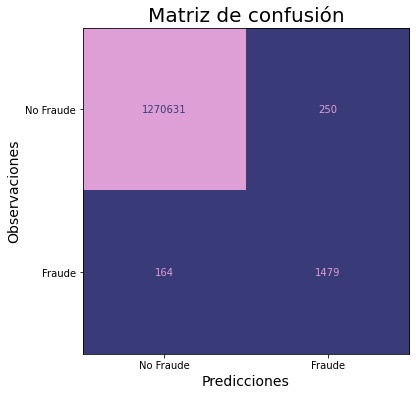

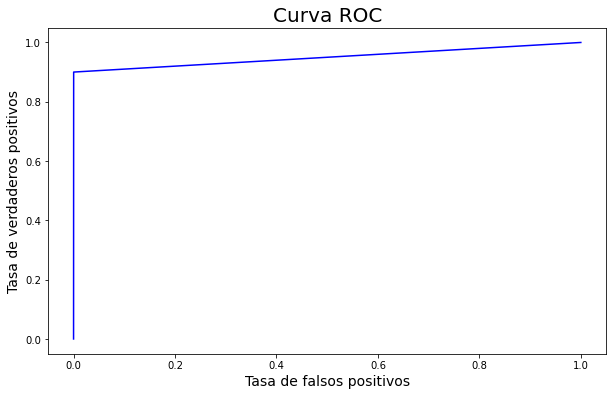

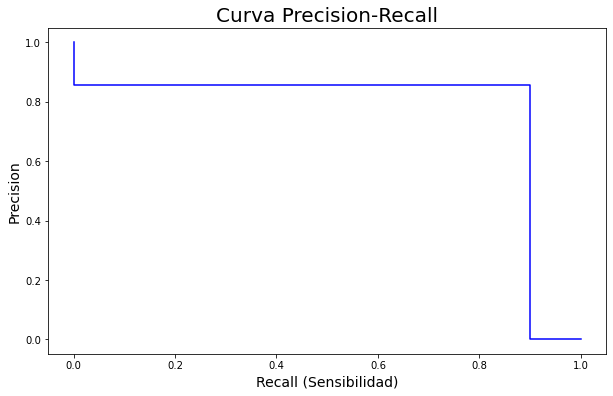

In [27]:
# Exportación a png.
from export import export_png
export_png(filename = 'xgb_balanced', y_test = y_test, y_pred = y_pred)